In [55]:

import os
path = "/Users/andreasnilsson/Library/CloudStorage/OneDrive-Nstart/Skrivbordet/Repository Homes/Behavior_Scorecard-DATA-223/2. Code/Classes"
os.chdir(path)

from Preprocessing_Application_N import DataPreprocessor



server = 'reporting-db.nystartfinans.net'
database = 'reporting-db'
username = 'Andreas'
password = 'nCq8Sg@1lYnd(E'
path = "/Users/andreasnilsson/Library/CloudStorage/OneDrive-Nstart/Skrivbordet/Repository Homes/Behavior_Scorecard-DATA-223/1. Data/Loan Portfolio Deli.sql"
driver = '{ODBC Driver 17 for SQL Server}'  # This is an example for SQL Server, adjust according to your database and installed ODBC driver


# Initialize DataPreprocessor with all required parameters, including the driver
processor = DataPreprocessor(server, database, username, password, driver)

df = processor.fetch_data_from_sql(path)

#df.to_csv('BSC_Today.csv', index=False)

/Users/andreasnilsson/Library/CloudStorage/OneDrive-Nstart/Skrivbordet/Repository Homes/Behavior_Scorecard-DATA-223/2. Code/Classes/Preprocessing_Application_N.py:35: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(sql_query, con=self.conn)


Error fetching data: Execution failed on sql: 
WITH  DelinquencyInfo AS 

(
    SELECT
        LP.SnapshotDate,
        A.SSN,
        MAX(CASE
            WHEN DelinquencyStatusCode = 9 THEN 9 
            WHEN NumberOfLateStatements >= 5 THEN 5 
            ELSE DelinquencyStatusCode
        END) AS Delinquency,
        MAX(CASE
            WHEN PFM.AccountNumber IS NOT NULL THEN 1
            ELSE 0
        END) AS FBE,
        SUM(LP.CurrentAmount) AS Balance,
        DD.IsMonthEnd
    FROM nystart.LoanPortfolio LP
    JOIN nystart.Applications A ON A.AccountNumber = LP.AccountNumber AND A.DisbursedDate = LP.DisbursedDate
    LEFT JOIN nystart.PaymentFreeMonths PFM ON LP.AccountNumber = PFM.AccountNumber 
                                             AND YEAR(LP.SnapshotDate) * 100 + MONTH(LP.SnapshotDate) = PFM.YearMonth
    LEFT JOIN nystart.DateDim DD ON LP.SnapshotDate = DD.Date
    WHERE LP.SnapshotDate > DATEADD(MONTH, -6, GETDATE())    --and LP.AccountNumber =7798630
    GROU

DatabaseError: Execution failed on sql: 
WITH  DelinquencyInfo AS 

(
    SELECT
        LP.SnapshotDate,
        A.SSN,
        MAX(CASE
            WHEN DelinquencyStatusCode = 9 THEN 9 
            WHEN NumberOfLateStatements >= 5 THEN 5 
            ELSE DelinquencyStatusCode
        END) AS Delinquency,
        MAX(CASE
            WHEN PFM.AccountNumber IS NOT NULL THEN 1
            ELSE 0
        END) AS FBE,
        SUM(LP.CurrentAmount) AS Balance,
        DD.IsMonthEnd
    FROM nystart.LoanPortfolio LP
    JOIN nystart.Applications A ON A.AccountNumber = LP.AccountNumber AND A.DisbursedDate = LP.DisbursedDate
    LEFT JOIN nystart.PaymentFreeMonths PFM ON LP.AccountNumber = PFM.AccountNumber 
                                             AND YEAR(LP.SnapshotDate) * 100 + MONTH(LP.SnapshotDate) = PFM.YearMonth
    LEFT JOIN nystart.DateDim DD ON LP.SnapshotDate = DD.Date
    WHERE LP.SnapshotDate > DATEADD(MONTH, -6, GETDATE())    --and LP.AccountNumber =7798630
    GROUP BY LP.SnapshotDate, A.SSN, DD.IsMonthEnd
),

deli1 as (

select *,
	   MAX(case when Delinquency=1 then  SnapshotDate else null end) over (partition by SSN order by SnapshotDate rows between unbounded preceding and current row) as Last1DateE,
	   MAX(case when Delinquency=2 then  SnapshotDate else null end) over (partition by SSN order by SnapshotDate rows between unbounded preceding and current row) as Last30DateE,
	   MAX(case when Delinquency=3 then  SnapshotDate else null end) over (partition by SSN order by SnapshotDate rows between unbounded preceding and current row) as Last60DateE,
	   MAX(case when Delinquency=4 then  SnapshotDate else null end) over (partition by SSN order by SnapshotDate rows between unbounded preceding and current row) as Last90DateE,
	   MAX(case when Delinquency=5 then  SnapshotDate else null end) over (partition by SSN order by SnapshotDate rows between unbounded preceding and current row) as Last120DateE,
	   MAX(case when Delinquency>1 then  SnapshotDate else null end) over (partition by SSN order by SnapshotDate rows between unbounded preceding and current row) as Last30Date,
	   MAX(case when Delinquency>2 then  SnapshotDate else null end) over (partition by SSN order by SnapshotDate rows between unbounded preceding and current row) as Last60Date,
	   MAX(case when Delinquency>3 then  SnapshotDate else null end) over (partition by SSN order by SnapshotDate rows between unbounded preceding and current row) as Last90Date,
	   MAX(case when Delinquency>4 then  SnapshotDate else null end) over (partition by SSN order by SnapshotDate rows between unbounded preceding and current row) as Last120Date,
	   MAX(case when FBE=1 then SnapshotDate else null end) over (partition by SSN order by SnapshotDate rows between unbounded preceding and current row) as LastFBEDate,
	   Min(case when Delinquency>1 then  SnapshotDate else null end) over (partition by SSN order by SnapshotDate rows between 1 following and unbounded following) as Next30Date,
	   Min(case when Delinquency>2 then  SnapshotDate else null end) over (partition by SSN order by SnapshotDate rows between 1 following and unbounded following) as Next60Date,
	   Min(case when Delinquency>3 then  SnapshotDate else null end) over (partition by SSN order by SnapshotDate rows between 1 following and unbounded following) as Next90Date,
	   Min(case when Delinquency>4 then  SnapshotDate else null end) over (partition by SSN order by SnapshotDate rows between 1 following and unbounded following) as Next120Date,
	   Min(case when Delinquency=9 then  SnapshotDate else null end) over (partition by SSN order by SnapshotDate rows between 1 following and unbounded following) as NextFrozenDate,
	   Min(case when FBE=1 then SnapshotDate else null end) over (partition by SSN order by SnapshotDate rows between 1 following and unbounded following) as NextFBEDate  --
​

from DelinquencyInfo ) 

,


deliFinal2  as (
select d1.*,
	   datediff(DAY,d1.Last30DateE,d1.SnapshotDate) as TimeSince30,
	   datediff(DAY,d1.Last60DateE,d1.SnapshotDate) as TimeSince60,
	   datediff(DAY,d1.Last90DateE,d1.SnapshotDate) as TimeSince90,
	   datediff(DAY,d1.Last120DateE,d1.SnapshotDate) as TimeSince120,
	   case when DATEADD(month,6,d1.Last30Date)>=d1.SnapshotDate then 1 else 0 end as Ever30In6Months,
	   case when DATEADD(month,12,d1.Last30Date)>=d1.SnapshotDate then 1 else 0 end as Ever30In12Months,
	   case when d1.Last30Date is not null then 1 else 0 end as Ever30,
	   case when DATEADD(month,6,d1.Last60Date)>=d1.SnapshotDate then 1 else 0 end as Ever60In6Months,
	   case when DATEADD(month,12,d1.Last60Date)>=d1.SnapshotDate then 1 else 0 end as Ever60In12Months,
	   case when d1.Last60Date is not null then 1 else 0 end as Ever60,
	   case when DATEADD(month,6,d1.Last90Date)>=d1.SnapshotDate then 1 else 0 end as Ever90In6Months,
	   case when DATEADD(month,12,d1.Last90Date)>=d1.SnapshotDate then 1 else 0 end as Ever90In12Months,
	   case when d1.Last90Date is not null then 1 else 0 end as Ever90,
	   case when DATEADD(month,6,d1.Last120Date)>=d1.SnapshotDate then 1 else 0 end as Ever120In6Months,
	   case when DATEADD(month,12,d1.Last120Date)>=d1.SnapshotDate then 1 else 0 end as Ever120In12Months,
	   case when d1.Last120Date is not null then 1 else 0 end as Ever120,
	   case when DATEADD(month,6,d1.Last120Date)>=d1.SnapshotDate then 5
			when DATEADD(month,6,d1.Last90Date)>=d1.SnapshotDate then 4
	        when DATEADD(month,6,d1.Last60Date)>=d1.SnapshotDate then 3
	        when DATEADD(month,6,d1.Last30Date)>=d1.SnapshotDate then 2
	        when DATEADD(month,6,d1.Last1DateE)>=d1.SnapshotDate then 1
			else 0
	   end as WorstDelinquency6M,
	   case when DATEADD(month,12,d1.Last120Date)>=d1.SnapshotDate then 5
			when DATEADD(month,12,d1.Last90Date)>=d1.SnapshotDate then 4
	        when DATEADD(month,12,d1.Last60Date)>=d1.SnapshotDate then 3
	        when DATEADD(month,12,d1.Last30Date)>=d1.SnapshotDate then 2
	        when DATEADD(month,12,d1.Last1DateE)>=d1.SnapshotDate then 1
			else 0
	   end as WorstDelinquency12M,
	   case when d1.Last120Date IS not null then 5
			when d1.Last90Date IS not null then 4
	        when d1.Last60Date is not null then 3
	        when d1.Last30Date is not null then 2
	        when d1.Last1DateE is not null then 1
			else 0
	   end as WorstDelinquency,
	   datediff(DAY,d1.LastFBEDate,d1.SnapshotDate) as TimeSinceFBE,
	   case when DATEADD(month,6,d1.LastFBEDate)>=d1.SnapshotDate then 1 else 0 end as EverFBEIn6Months,
	   case when DATEADD(month,12,d1.LastFBEDate)>=d1.SnapshotDate then 1 else 0 end as EverFBEIn12Months,
	   case when DATEADD(month,24,d1.LastFBEDate)>=d1.SnapshotDate then 1 else 0 end as EverFBEIn24Months,
	   case when DATEADD(month,36,d1.LastFBEDate)>=d1.SnapshotDate then 1 else 0 end as EverFBEIn36Months, --
	   case when DATEADD(month,48,d1.LastFBEDate)>=d1.SnapshotDate then 1 else 0 end as EverFBEIn48Months,
	   case when d1.LastFBEDate is not null then 1 else 0 end as EverFBE,
	   case when d1.Next30Date<= DATEADD(year,1,d1.SnapshotDate) then 1 else 0 end as Ever30After12Months,
	   case when d1.Next30Date<= DATEADD(year,2,d1.SnapshotDate) then 1 else 0 end as Ever30After24Months,
	   case when d1.Next30Date<= DATEADD(year,3,d1.SnapshotDate) then 1 else 0 end as Ever30After36Months,
	   case when d1.Next30Date<= DATEADD(year,4,d1.SnapshotDate) then 1 else 0 end as Ever30After48Months,
	   case when d1.Next60Date<= DATEADD(year,1,d1.SnapshotDate) then 1 else 0 end as Ever60After12Months,	
	   case when d1.Next60Date<= DATEADD(year,2,d1.SnapshotDate) then 1 else 0 end as Ever60After24Months,	
	   case when d1.Next60Date<= DATEADD(year,3,d1.SnapshotDate) then 1 else 0 end as Ever60After36Months,	
	   case when d1.Next60Date<= DATEADD(year,4,d1.SnapshotDate) then 1 else 0 end as Ever60After48Months,	
	   case when d1.Next90Date<= DATEADD(year,1,d1.SnapshotDate) then 1 else 0 end as Ever90After12Months,
	   case when d1.Next90Date<= DATEADD(year,2,d1.SnapshotDate) then 1 else 0 end as Ever90After24Months,
	   case when d1.Next90Date<= DATEADD(year,3,d1.SnapshotDate) then 1 else 0 end as Ever90After36Months,
	   case when d1.Next90Date<= DATEADD(year,4,d1.SnapshotDate) then 1 else 0 end as Ever90After48Months,
	   case when d1.Next120Date<= DATEADD(year,1,d1.SnapshotDate) then 1 else 0 end as Ever120After12Months,
	   case when d1.Next120Date<= DATEADD(year,2,d1.SnapshotDate) then 1 else 0 end as Ever120After24Months,
	   case when d1.Next120Date<= DATEADD(year,3,d1.SnapshotDate) then 1 else 0 end as Ever120After36Months,
	   case when d1.Next120Date<= DATEADD(year,4,d1.SnapshotDate) then 1 else 0 end as Ever120After48Months,
	   case when d1.NextFrozenDate<= DATEADD(year,1,d1.SnapshotDate) then 1 else 0 end as FrozenAfter12Months,
	   case when d1.NextFrozenDate<= DATEADD(year,2,d1.SnapshotDate) then 1 else 0 end as FrozenAfter24Months,
	   case when d1.NextFrozenDate<= DATEADD(year,3,d1.SnapshotDate) then 1 else 0 end as FrozenAfter36Months,
	   case when d1.NextFrozenDate<= DATEADD(year,4,d1.SnapshotDate) then 1 else 0 end as FrozenAfter48Months

from deli1 d1
where IsMonthEnd=1 ) 

,

deliFinal1 as (

select d1.*,
	  
	   d30.Balance as ExposureAtFirst30,
	   d60.Balance as ExposureAtFirst60,
	   df.Balance as ExposureAtFirstFrozen

from deliFinal2 d1

left join deli1 d30 on  d1.SSN=d30.SSN and d30.SnapshotDate=d1.Next30Date
left join deli1 d60 on  d1.SSN=d60.SSN and d60.SnapshotDate=d1.Next60Date
--left join #deli1 d90 on  d1.SSN=d90.SSN and d90.SnapshotDate=d1.Next90Date
--left join #deli1 d120 on  d1.SSN=d120.SSN and d120.SnapshotDate=d1.Next120Date
left join deli1 df on  d1.SSN=df.SSN and df.SnapshotDate=d1.NextFrozenDate

),

deliFinal as (


select d1.*,
	   d90.Balance as ExposureAtFirst90,
	   d120.Balance as ExposureAtFirst120


from deliFinal1 d1
left join deli1 d90 on  d1.SSN=d90.SSN and d90.SnapshotDate=d1.Next90Date
left join deli1 d120 on  d1.SSN=d120.SSN and d120.SnapshotDate=d1.Next120Date


​) 
,

base1	as (

select LP.SnapshotDate,
	   D.IsMonthEnd,
	   LP.AccountNumber,
	   case when LP.IsOpen=1 and DelinquencyStatus='Frozen' then 'FROZEN'
			when LP.IsOpen=1 and DelinquencyStatus<>'Frozen' then 'OPEN'
			else 'CLOSED'
	   end as AccountStatus,
	   CurrentAmount,
	   MOB,
	   LP.DisbursedDate as DisbursedDate,
	   RemainingTenor,
	   1-IsMainApplicant as CoappFlag,
	   case when A.Kronofogden=1 then 1 else 0 end as Kronofogden,
	   case when isnull(A.Kronofogden,0)=0 then 1 else 0 end as NoKronofogden,
	   A.SSN,
	   DelinquencyStatusCode as CurrentDelinquencyStatus,
	   FBE,
	  TimeSince30,	
      TimeSince60,	
	  TimeSince90,	
	  TimeSince120,	
	  Ever30In6Months,
	  Ever30In12Months,	
	  dF.Ever30,	
	  Ever60In6Months,	
	  Ever60In12Months,	
	  dF.Ever60,	
	  Ever90In6Months,	
	  Ever90In12Months,	
	  dF.Ever90,	
	  Ever120In6Months,	
	  Ever120In12Months,	
	  dF.Ever120,	
	  WorstDelinquency6M,	
	  WorstDelinquency12M,	
	  WorstDelinquency	,
	  TimeSinceFBE,	
	  EverFBEIn6Months,	
	  EverFBEIn12Months,	
	  EverFBEIn24Months,	
	  EverFBEIn36Months,	
	  EverFBEIn48Months,	
	  EverFBE,	
	  Ever30After12Months,
	  Ever60After12Months,	
	  Ever90After12Months,	
	  Ever120After12Months,	
	  FrozenAfter12Months,
	  Ever30After24Months,
	  Ever60After24Months,	
	  Ever90After24Months,	
	  Ever120After24Months,	
	  FrozenAfter24Months,
	  Ever30After36Months,
	  Ever60After36Months,	
	  Ever90After36Months,	
	  Ever120After36Months,	
	  FrozenAfter36Months,
	  Ever30After48Months,
	  Ever60After48Months,	
	  Ever90After48Months,	
	  FrozenAfter48Months,
	  datediff(Month,LP.DisbursedDate,Next30Date) as TimeToFirst30,
	  datediff(Month,LP.DisbursedDate,Next60Date) as TimeToFirst60,
	  datediff(Month,LP.DisbursedDate,Next90Date) as TimeToFirst90,
	  datediff(Month,LP.DisbursedDate,Next120Date) as TimeToFirst120,
	  datediff(Month,LP.DisbursedDate,NextFrozenDate) as TimeToFirstFrozen,
	  ExposureAtFirst30,
	  ExposureAtFirst60,
	  ExposureAtFirst90,
	  ExposureAtFirst120,
	  ExposureAtFirstFrozen

base1	   
from nystart.LoanPortfolio LP
join  nystart.Applications A
on A.AccountNumber=LP.AccountNumber and A.DisbursedDate=LP.DisbursedDate
left join nystart.PaymentFreeMonths PFM
on LP.AccountNumber=PFM.AccountNumber and YEAR(LP.SnapshotDate)*100+Month(LP.SnapshotDate)=YearMonth
join nystart.DateDim D on D.Date=LP.SnapshotDate and IsMonthEnd=1
join deliFinal dF on dF.SSN=A.SSN and LP.SnapshotDate=dF.SnapshotDate

) ,



LatestStatus AS (
    SELECT 
        AccountNumber, 
        MAX(StartDate) AS LastStartDate
    FROM 
        [Reporting-db].[nystart].[Forbearance]
    WHERE 
        ForbearanceName NOT IN ('Skip a pay', '')
    GROUP BY 
        AccountNumber
)
,

LatestForberanceStatus as (

SELECT f.AccountNumber, f.StartDate as forberanceDate

FROM 
    [Reporting-db].[nystart].[Forbearance] AS f
INNER JOIN 
    LatestStatus AS l ON f.AccountNumber = l.AccountNumber AND f.StartDate = l.LastStartDate
WHERE 
    f.ForbearanceName NOT IN ('Skip a pay', '')

) , 


ForberanceLogic as (  


SELECT b.*, 
       l.forberanceDate,
       CASE WHEN DATEADD(month, 3, l.forberanceDate) > b.SnapshotDate AND b.SnapshotDate >= l.forberanceDate THEN 1 ELSE 0 END as ForberanceIn3Months,
       CASE WHEN DATEADD(month, 6, l.forberanceDate) > b.SnapshotDate AND b.SnapshotDate >= l.forberanceDate THEN 1 ELSE 0 END as ForberanceIn6Months,
       CASE WHEN DATEADD(month, 9, l.forberanceDate) > b.SnapshotDate AND b.SnapshotDate >= l.forberanceDate THEN 1 ELSE 0 END as ForberanceIn9Months,
       CASE WHEN DATEADD(month, 12, l.forberanceDate) > b.SnapshotDate AND b.SnapshotDate >= l.forberanceDate THEN 1 ELSE 0 END as ForberanceIn12Months
FROM base1 as b
LEFT JOIN LatestForberanceStatus as l ON b.AccountNumber = l.AccountNumber


)



select b.*,cs.Score,cs.RiskClass

from ForberanceLogic b
left join nystart.CustomerScore cs on cs.AccountNumber=b.AccountNumber and cs.SnapshotDate=b.SnapshotDate

order by b.CoappFlag , b.MOB

<class 'pyodbc.Error'> returned a result with an error set
unable to rollback

THE SQL CODE NEEDS TO BE WRITEN IN CTE STYLE, IF NOT THIS SETUP WILL NOT WORK

In [9]:
pd.set_option('display.max_columns', None)
df[(df.ForberanceIn6Months == 1) & (df.WorstDelinquency12M > 0)]   #     # (df.AccountNumber == '7931488')

,SnapshotDate,IsMonthEnd,AccountNumber,AccountStatus,CurrentAmount,MOB,DisbursedDate,RemainingTenor,CoappFlag,Kronofogden,NoKronofogden,SSN,CurrentDelinquencyStatus,FBE,TimeSince30,TimeSince60,TimeSince90,TimeSince120,Ever30In6Months,Ever30In12Months,Ever30,Ever60In6Months,Ever60In12Months,Ever60,Ever90In6Months,Ever90In12Months,Ever90,Ever120In6Months,Ever120In12Months,Ever120,WorstDelinquency6M,WorstDelinquency12M,WorstDelinquency,TimeSinceFBE,EverFBEIn6Months,EverFBEIn12Months,EverFBEIn24Months,EverFBEIn36Months,EverFBEIn48Months,EverFBE,Ever30After12Months,Ever60After12Months,Ever90After12Months,Ever120After12Months,FrozenAfter12Months,Ever30After24Months,Ever60After24Months,Ever90After24Months,Ever120After24Months,FrozenAfter24Months,Ever30After36Months,Ever60After36Months,Ever90After36Months,Ever120After36Months,FrozenAfter36Months,Ever30After48Months,Ever60After48Months,Ever90After48Months,FrozenAfter48Months,TimeToFirst30,TimeToFirst60,TimeToFirst90,TimeToFirst120,TimeToFirstFrozen,ExposureAtFirst30,ExposureAtFirst60,ExposureAtFirst90,ExposureAtFirst120,base1,forberanceDate,ForberanceIn3Months,ForberanceIn6Months,ForberanceIn9Months,ForberanceIn12Months,Score,RiskClass
5111,2023-10-31,1,7904204,OPEN,179838.25,5,2023-05-03,174,0,1,0,E0C875781AE62979F4DCD422ED8D6D78542BC21EAF76EC...,0,0,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,None,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2023-10-25,1,1,1,1,1.877308,E3
5231,2023-12-31,1,7931488,OPEN,5675.83,5,2023-07-13,55,0,0,1,C8380385BF49F4F8A49323A7850D8064C267F9E408DCD5...,0,0,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,None,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2023-12-06,1,1,1,1,4.595843,E4
5780,2024-01-31,1,7941370,OPEN,465899.10,5,2023-08-09,174,0,0,1,2E50C72A0B4C6A69F7CF1D1DE1A1468B4113EA9154331E...,2,0,0.0,NaN,NaN,NaN,1,1,1,0,0,0,0,0,0,0,0,0,2,2,2,None,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,6.0,NaN,NaN,NaN,NaN,465899.1,NaN,NaN,NaN,NaN,2024-01-23,1,1,1,1,63.410000,E6
6133,2023-11-30,1,7910219,OPEN,298356.09,6,2023-05-11,233,0,0,1,1F2B022FA050EDDBEB3DAF4E37320396A16B497F5BB2FA...,0,0,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,None,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2023-11-16,1,1,1,1,4.595843,E4
6373,2024-01-31,1,7930696,OPEN,264822.98,6,2023-07-13,174,0,0,1,58B4138FB42F32C3D40F737F7A9764DBB10C4F5F8A15B3...,0,0,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,None,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2024-01-17,1,1,1,1,4.595843,E4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
108442,2023-12-31,1,5001326,OPEN,75278.70,93,2016-03-29,51,1,0,1,8704251415,0,0,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,None,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2023-10-24,1,1,1,1,1.877308,E3
108457,2023-11-30,1,5001086,OPEN,112954.23,93,2016-02-15,51,1,0,1,7703267133,0,0,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,None,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2023-09-25,1,1,1,1,1.877308,E3
108501,2024-01-31,1,5001326,OPEN,75278.70,94,2016-03-29,50,1,0,1,8704251415,1,0,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,None,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2023-10-24,0,1,1,1,13.185339,E5
108502,2023-12-31,1,5001086,OPEN,111596.97,94,2016-02-15,50,1,0,1,7703267133,0,0,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,None,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2023-09-25,0,1,1,1,1.877308,E3


In [ ]:
df[(df.ForberanceIn6Months == 1) & (df.WorstDelinquency12M > 0)]  

In [10]:
df[(df.AccountNumber == '7904204')]   #     # 

,SnapshotDate,IsMonthEnd,AccountNumber,AccountStatus,CurrentAmount,MOB,DisbursedDate,RemainingTenor,CoappFlag,Kronofogden,NoKronofogden,SSN,CurrentDelinquencyStatus,FBE,TimeSince30,TimeSince60,TimeSince90,TimeSince120,Ever30In6Months,Ever30In12Months,Ever30,Ever60In6Months,Ever60In12Months,Ever60,Ever90In6Months,Ever90In12Months,Ever90,Ever120In6Months,Ever120In12Months,Ever120,WorstDelinquency6M,WorstDelinquency12M,WorstDelinquency,TimeSinceFBE,EverFBEIn6Months,EverFBEIn12Months,EverFBEIn24Months,EverFBEIn36Months,EverFBEIn48Months,EverFBE,Ever30After12Months,Ever60After12Months,Ever90After12Months,Ever120After12Months,FrozenAfter12Months,Ever30After24Months,Ever60After24Months,Ever90After24Months,Ever120After24Months,FrozenAfter24Months,Ever30After36Months,Ever60After36Months,Ever90After36Months,Ever120After36Months,FrozenAfter36Months,Ever30After48Months,Ever60After48Months,Ever90After48Months,FrozenAfter48Months,TimeToFirst30,TimeToFirst60,TimeToFirst90,TimeToFirst120,TimeToFirstFrozen,ExposureAtFirst30,ExposureAtFirst60,ExposureAtFirst90,ExposureAtFirst120,base1,forberanceDate,ForberanceIn3Months,ForberanceIn6Months,ForberanceIn9Months,ForberanceIn12Months,Score,RiskClass
2876,2023-08-31,1,7904204,OPEN,176567.42,3,2023-05-03,176,0,1,0,E0C875781AE62979F4DCD422ED8D6D78542BC21EAF76EC...,0,0,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,None,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2023-10-25,0,0,0,0,1.484099,E3
4592,2023-09-30,1,7904204,OPEN,176441.95,4,2023-05-03,175,0,1,0,E0C875781AE62979F4DCD422ED8D6D78542BC21EAF76EC...,0,0,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,None,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2023-10-25,0,0,0,0,1.877308,E3
5111,2023-10-31,1,7904204,OPEN,179838.25,5,2023-05-03,174,0,1,0,E0C875781AE62979F4DCD422ED8D6D78542BC21EAF76EC...,0,0,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,None,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2023-10-25,1,1,1,1,1.877308,E3
6868,2023-11-30,1,7904204,OPEN,179705.34,6,2023-05-03,173,0,1,0,E0C875781AE62979F4DCD422ED8D6D78542BC21EAF76EC...,0,0,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,None,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2023-10-25,1,1,1,1,1.877308,E3
7508,2023-12-31,1,7904204,OPEN,179705.34,7,2023-05-03,172,0,1,0,E0C875781AE62979F4DCD422ED8D6D78542BC21EAF76EC...,1,0,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,None,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2023-10-25,1,1,1,1,13.185339,E5
9432,2024-01-31,1,7904204,OPEN,179569.90,8,2023-05-03,171,0,1,0,E0C875781AE62979F4DCD422ED8D6D78542BC21EAF76EC...,1,0,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,None,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2023-10-25,0,1,1,1,13.185339,E5
83475,2023-08-31,1,7904204,OPEN,176567.42,3,2023-05-03,176,1,0,1,3E9F6D6B2E8285C7E46EECDDC6D47DBFAEF29AB19A9BF5...,0,0,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,None,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2023-10-25,0,0,0,0,1.484099,E3
83933,2023-09-30,1,7904204,OPEN,176441.95,4,2023-05-03,175,1,0,1,3E9F6D6B2E8285C7E46EECDDC6D47DBFAEF29AB19A9BF5...,0,0,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,None,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2023-10-25,0,0,0,0,1.877308,E3
84057,2023-10-31,1,7904204,OPEN,179838.25,5,2023-05-03,174,1,0,1,3E9F6D6B2E8285C7E46EECDDC6D47DBFAEF29AB19A9BF5...,0,0,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,None,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2023-10-25,1,1,1,1,1.877308,E3
84491,2023-11-30,1,7904204,OPEN,179705.34,6,2023-05-03,173,1,0,1,3E9F6D6B2E8285C7E46EECDDC6D47DBFAEF29AB19A9BF5...,0,0,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,None,0,0,0,0,0,0,0,0,0,0

In [56]:
path = "/Users/andreasnilsson/Library/CloudStorage/OneDrive-Nstart/Skrivbordet/Repository Homes/Behavior_Scorecard-DATA-223/1. Data"
os.chdir(path)

df.to_csv('BSC_Today.csv', index=False)



In [11]:
df

,SnapshotDate,IsMonthEnd,AccountNumber,AccountStatus,CurrentAmount,MOB,DisbursedDate,RemainingTenor,CoappFlag,Kronofogden,NoKronofogden,SSN,CurrentDelinquencyStatus,FBE,TimeSince30,TimeSince60,TimeSince90,TimeSince120,Ever30In6Months,Ever30In12Months,Ever30,Ever60In6Months,Ever60In12Months,Ever60,Ever90In6Months,Ever90In12Months,Ever90,Ever120In6Months,Ever120In12Months,Ever120,WorstDelinquency6M,WorstDelinquency12M,WorstDelinquency,TimeSinceFBE,EverFBEIn6Months,EverFBEIn12Months,EverFBEIn24Months,EverFBEIn36Months,EverFBEIn48Months,EverFBE,Ever30After12Months,Ever60After12Months,Ever90After12Months,Ever120After12Months,FrozenAfter12Months,Ever30After24Months,Ever60After24Months,Ever90After24Months,Ever120After24Months,FrozenAfter24Months,Ever30After36Months,Ever60After36Months,Ever90After36Months,Ever120After36Months,FrozenAfter36Months,Ever30After48Months,Ever60After48Months,Ever90After48Months,FrozenAfter48Months,TimeToFirst30,TimeToFirst60,TimeToFirst90,TimeToFirst120,TimeToFirstFrozen,ExposureAtFirst30,ExposureAtFirst60,ExposureAtFirst90,ExposureAtFirst120,base1,forberanceDate,ForberanceIn3Months,ForberanceIn6Months,ForberanceIn9Months,ForberanceIn12Months,Score,RiskClass
0,2023-08-31,1,7944036,OPEN,55376.36,0,2023-08-10,35,0,0,1,00500A2C27C680EECD0BF4C1A1F7D7D8D98B24F228DFA2...,0,0,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,None,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,0,0,0,0,3.202777,N2
1,2023-09-30,1,7957772,OPEN,175275.31,0,2023-09-13,60,0,0,1,003AE4E39515E6B2DE70EDAC983260BFDD9F2656A95AD5...,0,0,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,None,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,0,0,0,0,3.878741,N2
2,2023-11-30,1,7982101,OPEN,108014.00,0,2023-11-29,144,0,0,1,0034FF6CE49A8CDED9BA200D3B0D24392B207B33776D6A...,0,0,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,None,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,0,0,0,0,4.272936,N2
3,2023-12-31,1,7980527,OPEN,87328.92,0,2023-12-01,35,0,1,0,012C9EC720A46275AABA4E6036C1850682C9BDBBE94CEC...,0,0,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,None,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,0,0,0,0,1.622251,N1
4,2023-09-30,1,7960545,OPEN,200000.00,0,2023-09-28,144,0,0,1,0398990135F27D0F70DACA3B34BFDC91184A889DA72F9B...,0,0,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,None,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,0,0,0,0,3.054894,N2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
108651,2024-01-31,1,5000286,CLOSED,0.00,100,2015-09-11,0,1,0,1,7708237446,0,0,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,None,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,0,0,0,0,NaN,None
108652,2024-01-31,1,5000047,CLOSED,0.00,100,2015-09-22,118,1,0,1,7112206177,0,0,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,None,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,0,0,0,0,NaN,None
108653,2024-01-31,1,5000104,CLOSED,0.00,100,2015-09-25,68,1,0,1,8410174885,0,0,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,None,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,0,0,0,0,NaN,None
108654,2024-01-31,1,5000054,OPEN,174956.25,100,2015-09-16,44,1,0,1,8205102075,0,0,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,None,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,0,0,0,0,1.484099,E3


In [57]:
import pandas as pd
import numpy as np
import datetime
import os
import matplotlib.pyplot as plt

In [58]:
path = "/Users/andreasnilsson/Library/CloudStorage/OneDrive-Nstart/Skrivbordet/Repository Homes/Behavior_Scorecard-DATA-223/1. Data"
os.chdir(path)

df = pd.read_csv('BSC_Today.csv')



In [59]:

main = df[df.CoappFlag == 0]

co = df[df.CoappFlag == 1]

main = main[~main.AccountNumber.isin(co.AccountNumber)]

df = pd.concat([main,co])

# This was just a control to reconsile the number of accounts
# konton = df[ (df.AccountStatus.isin(['OPEN','FROZEN'])) & (df.SnapshotDate == max(df.SnapshotDate))   ]

In [60]:
df[df.AccountNumber == 7156474].sort_values('MOB')

,SnapshotDate,IsMonthEnd,AccountNumber,AccountStatus,CurrentAmount,MOB,DisbursedDate,RemainingTenor,CoappFlag,Kronofogden,NoKronofogden,SSN,CurrentDelinquencyStatus,FBE,TimeSince30,TimeSince60,TimeSince90,TimeSince120,Ever30In6Months,Ever30In12Months,Ever30,Ever60In6Months,Ever60In12Months,Ever60,Ever90In6Months,Ever90In12Months,Ever90,Ever120In6Months,Ever120In12Months,Ever120,WorstDelinquency6M,WorstDelinquency12M,WorstDelinquency,TimeSinceFBE,EverFBEIn6Months,EverFBEIn12Months,EverFBEIn24Months,EverFBEIn36Months,EverFBEIn48Months,EverFBE,Ever30After12Months,Ever60After12Months,Ever90After12Months,Ever120After12Months,FrozenAfter12Months,Ever30After24Months,Ever60After24Months,Ever90After24Months,Ever120After24Months,FrozenAfter24Months,Ever30After36Months,Ever60After36Months,Ever90After36Months,Ever120After36Months,FrozenAfter36Months,Ever30After48Months,Ever60After48Months,Ever90After48Months,FrozenAfter48Months,TimeToFirst30,TimeToFirst60,TimeToFirst90,TimeToFirst120,TimeToFirstFrozen,ExposureAtFirst30,ExposureAtFirst60,ExposureAtFirst90,ExposureAtFirst120,base1,forberanceDate,ForberanceIn3Months,ForberanceIn6Months,ForberanceIn9Months,ForberanceIn12Months,Score,RiskClass
38631,2023-08-31,1,7156474,FROZEN,99481.01,40,2020-04-22,155,0,0,1,38209C198E7E5DE90EA46DCD60CD5C340CBEF7BE3EA799...,9,0,NaN,NaN,NaN,NaN,1,1,1,1,1,1,1,1,1,1,1,1,5,5,5,NaN,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,41.0,41.0,41.0,41.0,41.0,99481.01,99481.01,99481.01,99481.01,99481.01,NaN,0,0,0,0,100.0,E8
38938,2023-09-30,1,7156474,FROZEN,99481.01,41,2020-04-22,155,0,0,1,38209C198E7E5DE90EA46DCD60CD5C340CBEF7BE3EA799...,9,0,NaN,NaN,NaN,NaN,1,1,1,1,1,1,1,1,1,1,1,1,5,5,5,NaN,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,42.0,42.0,42.0,42.0,42.0,99481.01,99481.01,99481.01,99481.01,99481.01,NaN,0,0,0,0,100.0,E8
40068,2023-10-31,1,7156474,FROZEN,99481.01,42,2020-04-22,155,0,0,1,38209C198E7E5DE90EA46DCD60CD5C340CBEF7BE3EA799...,9,0,NaN,NaN,NaN,NaN,1,1,1,1,1,1,1,1,1,1,1,1,5,5,5,NaN,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,43.0,43.0,43.0,43.0,43.0,99481.01,99481.01,99481.01,99481.01,99481.01,NaN,0,0,0,0,100.0,E8
40219,2023-11-30,1,7156474,FROZEN,99481.01,43,2020-04-22,155,0,0,1,38209C198E7E5DE90EA46DCD60CD5C340CBEF7BE3EA799...,9,0,NaN,NaN,NaN,NaN,1,1,1,1,1,1,1,1,1,1,1,1,5,5,5,NaN,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,44.0,44.0,44.0,44.0,44.0,99481.01,99481.01,99481.01,99481.01,99481.01,NaN,0,0,0,0,100.0,E8
41477,2023-12-31,1,7156474,FROZEN,99481.01,44,2020-04-22,155,0,0,1,38209C198E7E5DE90EA46DCD60CD5C340CBEF7BE3EA799...,9,0,NaN,NaN,NaN,NaN,1,1,1,1,1,1,1,1,1,1,1,1,5,5,5,NaN,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,45.0,45.0,45.0,45.0,45.0,99481.01,99481.01,99481.01,99481.01,99481.01,NaN,0,0,0,0,100.0,E8
41562,2024-01-31,1,7156474,FROZEN,99198.69,45,2020-04-22,155,0,0,1,38209C198E7E5DE90EA46DCD60CD5C340CBEF7BE3EA799...,9,0,NaN,NaN,NaN,NaN,1,1,1,1,1,1,1,1,1,1,1,1,5,5,5,NaN,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,46.0,46.0,46.0,46.0,46.0,99198.69,99198.69,99198.69,99198.69,99198.69,NaN,0,0,0,0,100.0,E8


In [61]:
coefficients = np.array([-0.44414603,  0.18778622 , 0.3539554 ,  0.70178643])
intercept = np.array([0])


# Sample DataFrame (Assuming you already have this in place)
pd_ = df.copy()

# Coefficients and Intercept from the Logistic Regression model


print("Coefficients:", coefficients)
print("Intercept:", intercept)


# Compute the Z values using your logistic regression model
pd_['Z'] = (pd_.CoappFlag * coefficients[0] +
            pd_.Ever30In6Months * coefficients[1] + 
            pd_.WorstDelinquency6M * coefficients[2] +
            pd_.CurrentDelinquencyStatus * coefficients[3] +

            intercept[0]) 

# Compute the original probabilities
pd_['P'] = pd_['Z'].apply(lambda x: 1 / (1 + np.exp(-x)))

# Coefficients and Intercept from the Calibration model
calibration_coef = 9.82696528
calibration_intercept = -8.57437634


print("Coefficient:", calibration_coef)
print("Intercept:", calibration_intercept)

# Using the original probabilities to calibrate them with the calibration model
pd_['Z_calibrated'] = pd_['P'].apply(lambda x: x * calibration_coef + calibration_intercept)

# Compute the calibrated probabilities
pd_['BehaviourModel'] = pd_['Z_calibrated'].apply(lambda x: 1 / (1 + np.exp(-x)))


pd_

Coefficients: [-0.44414603  0.18778622  0.3539554   0.70178643]
Intercept: [0]
Coefficient: 9.82696528
Intercept: -8.57437634


,SnapshotDate,IsMonthEnd,AccountNumber,AccountStatus,CurrentAmount,MOB,DisbursedDate,RemainingTenor,CoappFlag,Kronofogden,NoKronofogden,SSN,CurrentDelinquencyStatus,FBE,TimeSince30,TimeSince60,TimeSince90,TimeSince120,Ever30In6Months,Ever30In12Months,Ever30,Ever60In6Months,Ever60In12Months,Ever60,Ever90In6Months,Ever90In12Months,Ever90,Ever120In6Months,Ever120In12Months,Ever120,WorstDelinquency6M,WorstDelinquency12M,WorstDelinquency,TimeSinceFBE,EverFBEIn6Months,EverFBEIn12Months,EverFBEIn24Months,EverFBEIn36Months,EverFBEIn48Months,EverFBE,Ever30After12Months,Ever60After12Months,Ever90After12Months,Ever120After12Months,FrozenAfter12Months,Ever30After24Months,Ever60After24Months,Ever90After24Months,Ever120After24Months,FrozenAfter24Months,Ever30After36Months,Ever60After36Months,Ever90After36Months,Ever120After36Months,FrozenAfter36Months,Ever30After48Months,Ever60After48Months,Ever90After48Months,FrozenAfter48Months,TimeToFirst30,TimeToFirst60,TimeToFirst90,TimeToFirst120,TimeToFirstFrozen,ExposureAtFirst30,ExposureAtFirst60,ExposureAtFirst90,ExposureAtFirst120,base1,forberanceDate,ForberanceIn3Months,ForberanceIn6Months,ForberanceIn9Months,ForberanceIn12Months,Score,RiskClass,Z,P,Z_calibrated,BehaviourModel
0,2023-08-31,1,7944036,OPEN,55376.36,0,2023-08-10,35,0,0,1,00500A2C27C680EECD0BF4C1A1F7D7D8D98B24F228DFA2...,0,0,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,3.202777,N2,0.000000,0.500000,-3.660894,0.025065
1,2023-09-30,1,7957772,OPEN,175275.31,0,2023-09-13,60,0,0,1,003AE4E39515E6B2DE70EDAC983260BFDD9F2656A95AD5...,0,0,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,3.878741,N2,0.000000,0.500000,-3.660894,0.025065
2,2023-11-30,1,7982101,OPEN,108014.00,0,2023-11-29,144,0,0,1,0034FF6CE49A8CDED9BA200D3B0D24392B207B33776D6A...,0,0,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,4.272936,N2,0.000000,0.500000,-3.660894,0.025065
3,2023-09-30,1,7960545,OPEN,200000.00,0,2023-09-28,144,0,0,1,0398990135F27D0F70DACA3B34BFDC91184A889DA72F9B...,0,0,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,3.054894,N2,0.000000,0.500000,-3.660894,0.025065
4,2023-09-30,1,7955321,OPEN,281361.46,0,2023-09-07,143,0,0,1,01C36A0D9407DDFB91305C1C5B1723E75F3A13D08B80B4...,0,0,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,1.622251,N1,0.000000,0.500000,-3.660894,0.025065
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
82575,2024-01-31,1,5000286,CLOSED,0.00,100,2015-09-11,0,1,0,1,7708237446,0,0,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,NaN,NaN,-0.444146,0.390753,-4.734455,0.008711
82576,2024-01-31,1,5000047,CLOSED,0.00,100,2015-09-22,118,1,0,1,7112206177,0,0,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,NaN,NaN,-0.444146,0.390753,-4.734455,0.008711
82577,2024-01-31,1,5000104,CLOSED,0.00,100,2015-09-25,68,1,0,1,8410174885,0,0,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,NaN,NaN,-0.444146,0.390753,-4.734455,0.008711
82578,2024-01-31,1,5000054,OPEN,174956.25,1

In [62]:
see = pd_[pd_.Score >-1]

## Without when the accounts are Zero after CLOSED

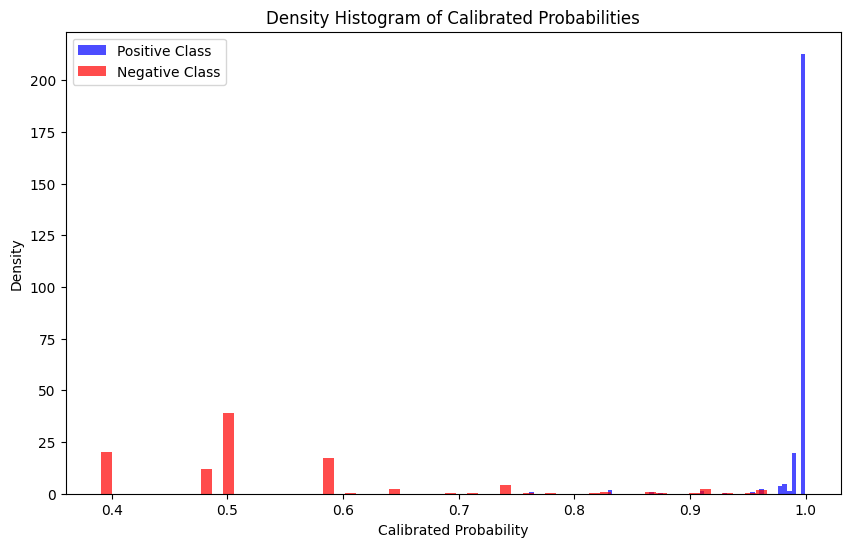

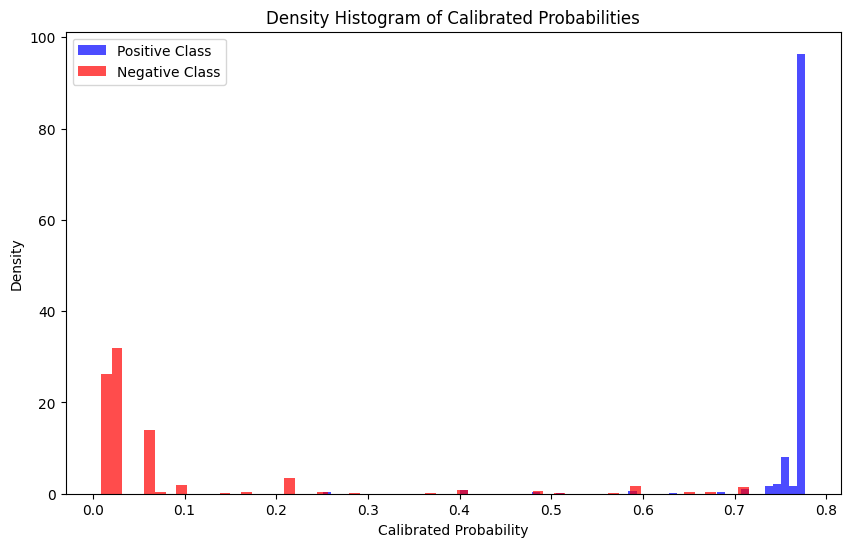

In [63]:
# Get the calibrated probabilities
calibrated_probabilities = see['P']

# Split the data into positive and negative classes
positive_class = calibrated_probabilities[see['Ever90'] == 1]
negative_class = calibrated_probabilities[see['Ever90'] == 0]

# Plot density histograms of calibrated probabilities
plt.figure(figsize=(10, 6))
plt.hist(positive_class, bins=60, color='blue', alpha=0.7, density=True, label='Positive Class')
plt.hist(negative_class, bins=60, color='red', alpha=0.7, density=True, label='Negative Class')
plt.xlabel('Calibrated Probability')
plt.ylabel('Density')
plt.title('Density Histogram of Calibrated Probabilities')
plt.legend()
plt.show()

# Get the calibrated probabilities
calibrated_probabilities = see['BehaviourModel']

# Split the data into positive and negative classes
positive_class = calibrated_probabilities[see['Ever90'] == 1]
negative_class = calibrated_probabilities[see['Ever90'] == 0]

# Plot density histograms of calibrated probabilities
plt.figure(figsize=(10, 6))
plt.hist(positive_class, bins=60, color='blue', alpha=0.7, density=True, label='Positive Class')
plt.hist(negative_class, bins=60, color='red', alpha=0.7, density=True, label='Negative Class')
plt.xlabel('Calibrated Probability')
plt.ylabel('Density')
plt.title('Density Histogram of Calibrated Probabilities')
plt.legend()
plt.show()



## ALL ACCOUNTS WITH CLOSED --> Zero

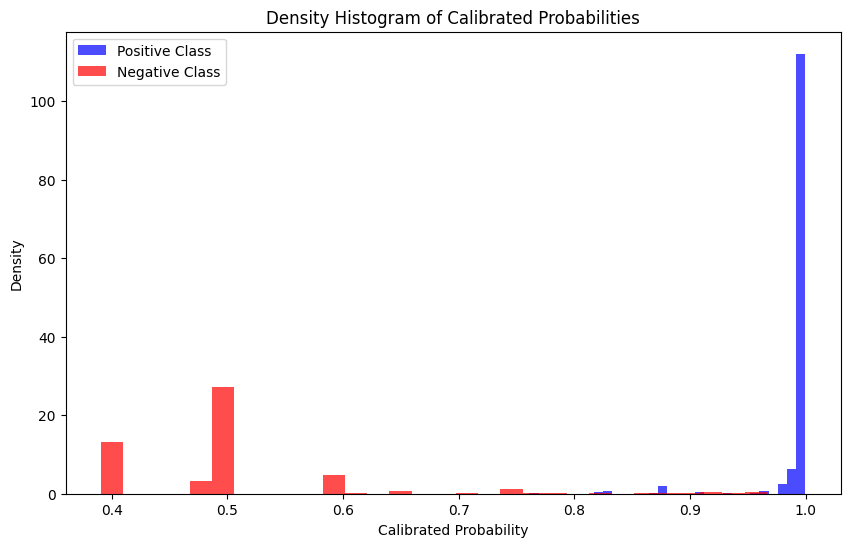

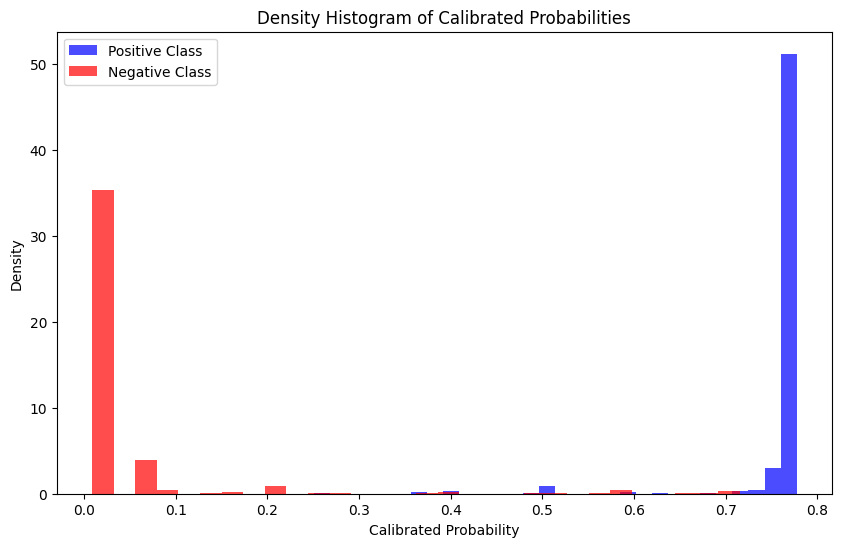

In [64]:
# Get the calibrated probabilities
calibrated_probabilities = pd_['P']

# Split the data into positive and negative classes
positive_class = calibrated_probabilities[pd_['Ever90'] == 1]
negative_class = calibrated_probabilities[pd_['Ever90'] == 0]

# Plot density histograms of calibrated probabilities
plt.figure(figsize=(10, 6))
plt.hist(positive_class, bins=30, color='blue', alpha=0.7, density=True, label='Positive Class')
plt.hist(negative_class, bins=30, color='red', alpha=0.7, density=True, label='Negative Class')
plt.xlabel('Calibrated Probability')
plt.ylabel('Density')
plt.title('Density Histogram of Calibrated Probabilities')
plt.legend()
plt.show()

# Get the calibrated probabilities
calibrated_probabilities = pd_['BehaviourModel']

# Split the data into positive and negative classes
positive_class = calibrated_probabilities[pd_['Ever90'] == 1]
negative_class = calibrated_probabilities[pd_['Ever90'] == 0]

# Plot density histograms of calibrated probabilities
plt.figure(figsize=(10, 6))
plt.hist(positive_class, bins=30, color='blue', alpha=0.7, density=True, label='Positive Class')
plt.hist(negative_class, bins=30, color='red', alpha=0.7, density=True, label='Negative Class')
plt.xlabel('Calibrated Probability')
plt.ylabel('Density')
plt.title('Density Histogram of Calibrated Probabilities')
plt.legend()
plt.show()



In [65]:
pd_ = pd_[['AccountNumber','AccountStatus','SnapshotDate',	'MOB'	,'DisbursedDate',	'CurrentAmount','RemainingTenor','CoappFlag',	'Ever30In6Months',	'WorstDelinquency6M','CurrentDelinquencyStatus','WorstDelinquency12M','Ever30In12Months','Ever90In12Months'	,'Score'	,'RiskClass','P','BehaviourModel','Ever90']]

In [66]:
pd_

,AccountNumber,AccountStatus,SnapshotDate,MOB,DisbursedDate,CurrentAmount,RemainingTenor,CoappFlag,Ever30In6Months,WorstDelinquency6M,CurrentDelinquencyStatus,WorstDelinquency12M,Ever30In12Months,Ever90In12Months,Score,RiskClass,P,BehaviourModel,Ever90
0,7944036,OPEN,2023-08-31,0,2023-08-10,55376.36,35,0,0,0,0,0,0,0,3.202777,N2,0.500000,0.025065,0
1,7957772,OPEN,2023-09-30,0,2023-09-13,175275.31,60,0,0,0,0,0,0,0,3.878741,N2,0.500000,0.025065,0
2,7982101,OPEN,2023-11-30,0,2023-11-29,108014.00,144,0,0,0,0,0,0,0,4.272936,N2,0.500000,0.025065,0
3,7960545,OPEN,2023-09-30,0,2023-09-28,200000.00,144,0,0,0,0,0,0,0,3.054894,N2,0.500000,0.025065,0
4,7955321,OPEN,2023-09-30,0,2023-09-07,281361.46,143,0,0,0,0,0,0,0,1.622251,N1,0.500000,0.025065,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
82575,5000286,CLOSED,2024-01-31,100,2015-09-11,0.00,0,1,0,0,0,0,0,0,NaN,NaN,0.390753,0.008711,0
82576,5000047,CLOSED,2024-01-31,100,2015-09-22,0.00,118,1,0,0,0,0,0,0,NaN,NaN,0.390753,0.008711,0
82577,5000104,CLOSED,2024-01-31,100,2015-09-25,0.00,68,1,0,0,0,0,0,0,NaN,NaN,0.390753,0.008711,0
82578,5000054,OPEN,2024-01-31,100,2015-09-16,174956.25,44,1,0,0,0,0,0,0,1.484099,E3,0.390753,0.008711,0


In [67]:
print(np.mean(pd_.P))
min(pd_.P)

0.5728796975370543


0.3907534979348959

In [68]:
print(np.mean(pd_.BehaviourModel))
max(pd_.BehaviourModel)

0.15235856820025948


0.7773140874043875

In [69]:
print(np.mean(see.P))
min(see.P)

0.6109630057220943


0.3907534979348959

In [70]:
pd_.tail(40)

,AccountNumber,AccountStatus,SnapshotDate,MOB,DisbursedDate,CurrentAmount,RemainingTenor,CoappFlag,Ever30In6Months,WorstDelinquency6M,CurrentDelinquencyStatus,WorstDelinquency12M,Ever30In12Months,Ever90In12Months,Score,RiskClass,P,BehaviourModel,Ever90
82540,5000294,FROZEN,2023-11-30,98,2015-09-25,338251.56,118,1,1,5,9,5,1,1,100.000000,E8,0.999602,0.777071,1
82541,5000419,FROZEN,2024-01-31,98,2015-11-05,143840.89,67,1,1,5,9,5,1,1,100.000000,E8,0.999602,0.777071,1
82542,5000054,OPEN,2023-11-30,98,2015-09-16,179524.83,46,1,0,0,0,0,0,0,1.484099,E3,0.390753,0.008711,0
82543,5000617,CLOSED,2024-01-31,98,2015-11-26,0.00,90,1,0,0,0,0,0,0,NaN,NaN,0.390753,0.008711,0
82544,5000385,FROZEN,2023-12-31,98,2015-10-26,224655.26,123,1,1,5,9,5,1,1,100.000000,E8,0.999602,0.777071,1
82545,5000575,CLOSED,2024-01-31,98,2015-11-23,0.00,135,1,0,0,0,0,0,0,NaN,NaN,0.390753,0.008711,0
82546,5000609,OPEN,2024-01-31,98,2015-11-26,101843.62,46,1,0,0,0,0,0,0,1.877308,E3,0.390753,0.008711,0
82547,5000302,CLOSED,2023-11-30,98,2015-09-23,0.00,142,1,0,0,0,0,0,0,NaN,NaN,0.390753,0.008711,0
82548,5000484,CLOSED,2024-01-31,98,2015-11-04,0.00,138,1,0,0,0,0,0,0,NaN,NaN,0.390753,0.008711,0
82549,5000286,CLOSED,2023-11-30,98,2015-09-11,0.00,0,1,0,0,0,0,0,0,NaN,NaN,0.390753,0.008711,0


In [71]:
BehaviourDone = pd_.copy()

In [72]:
BehaviourDone[BehaviourDone.AccountNumber ==  7257967].sort_values(by='MOB')

,AccountNumber,AccountStatus,SnapshotDate,MOB,DisbursedDate,CurrentAmount,RemainingTenor,CoappFlag,Ever30In6Months,WorstDelinquency6M,CurrentDelinquencyStatus,WorstDelinquency12M,Ever30In12Months,Ever90In12Months,Score,RiskClass,P,BehaviourModel,Ever90
27628,7257967,OPEN,2023-08-31,27,2021-05-17,260011.11,151,0,0,1,1,1,0,0,27.662599,E5,0.741876,0.216872,0
28233,7257967,OPEN,2023-09-30,28,2021-05-17,258849.35,150,0,0,1,0,1,0,0,4.595843,E4,0.587576,0.057309,0
29528,7257967,OPEN,2023-10-31,29,2021-05-17,258257.52,149,0,0,1,0,1,0,0,4.595843,E4,0.587576,0.057309,0
30099,7257967,OPEN,2023-11-30,30,2021-05-17,258257.52,148,0,0,1,1,1,0,0,27.662599,E5,0.741876,0.216872,0
31370,7257967,OPEN,2023-12-31,31,2021-05-17,257658.27,147,0,1,2,1,2,1,0,39.215327,E5,0.831666,0.400923,0
31966,7257967,OPEN,2024-01-31,32,2021-05-17,256287.73,146,0,1,2,0,2,1,0,7.516150,E4,0.710064,0.168458,0


In [73]:
# Assuming 'BehaviourDone' is your DataFrame and it includes a 'P_calibrated' column along with the other specified columns

# Group the DataFrame by the specified columns and count the number of occurrences in each group
grouped_counts = BehaviourDone.groupby(['BehaviourModel', 'CoappFlag', 'Ever30In6Months', 'WorstDelinquency6M', 'CurrentDelinquencyStatus']).size()

# Convert the resulting series to a DataFrame and reset the index, which turns the grouped columns into regular columns and adds a new 'Counts' column with the group counts
grouped_counts_df = grouped_counts.reset_index(name='Counts')

# Sort the DataFrame based on the specified columns. The 'ascending' list determines the sort order for each column (True for ascending, False for descending).
sorted_counts_df = grouped_counts_df.sort_values(by=['BehaviourModel', 'CoappFlag', 'Ever30In6Months', 'WorstDelinquency6M', 'CurrentDelinquencyStatus'], ascending=[True, True, True, True, True])

# Display the sorted DataFrame, which includes the counts for each unique combination of the group-by columns
sorted_counts_df['Counts%'] = sorted_counts_df['Counts'] / sum(sorted_counts_df['Counts'])
sorted_counts_df

,BehaviourModel,CoappFlag,Ever30In6Months,WorstDelinquency6M,CurrentDelinquencyStatus,Counts,Counts%
0,0.008711,1,0,0,0,17798,0.215524
1,0.020187,1,0,1,0,4303,0.052107
2,0.025065,0,0,0,0,36718,0.444636
3,0.057309,0,0,1,0,6431,0.077876
4,0.071093,1,1,2,0,141,0.001707
5,0.099436,1,0,1,1,805,0.009748
6,0.144000,1,1,3,0,60,0.000727
7,0.168458,0,1,2,0,238,0.002882
8,0.216872,0,0,1,1,1471,0.017813
9,0.248860,1,1,2,1,171,0.002071


# 2. Application Scores

In [74]:

main_path = "/Users/andreasnilsson/Library/CloudStorage/OneDrive-Nstart/Skrivbordet/Repository Homes/Admission-Scorecard-DATA-196/DATA/MA Correct join - APL CRB-MLP Today.sql"
co_path = "/Users/andreasnilsson/Library/CloudStorage/OneDrive-Nstart/Skrivbordet/Repository Homes/Admission-Scorecard-DATA-196/DATA/CO Min score join - APL CBR MLP Today.sql"

preprocessor = DataPreprocessor(server, database, username, password,driver)
final_df = preprocessor.process_data(main_path, co_path)


/Users/andreasnilsson/Library/CloudStorage/OneDrive-Nstart/Skrivbordet/Repository Homes/Behavior_Scorecard-DATA-223/2. Code/Classes/Preprocessing_Application_N.py:35: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(sql_query, con=self.conn)
/Users/andreasnilsson/Library/CloudStorage/OneDrive-Nstart/Skrivbordet/Repository Homes/Behavior_Scorecard-DATA-223/2. Code/Classes/Preprocessing_Application_N.py:231: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['PropertyVolume'] = np.where( df.MortgageLoansHouseVolume > 0, df.MortgageLoansHouseVolume,


In [75]:
final_df

,RowNumber,Ever30,Ever90,AccountNumber,ApplicationID,SSN_A,PDScoreNew,ApplicationScore,IsMainApplicant,HasCoapp,ReceivedDate,DisbursedDate,Amount,InterestRate,StartupFee,PaymentRemarks,CreditOfficer,SalesChannel,Product,Migrated,BrokerName,OriginalSalesChannel,BirthDate,Bookingtype,MaritalStatus,EmploymentType,HousingType,MonthlySalary,Referer,Campaign,SourceMedium,Keyword,NystartChannel,PNReceivedDate,NumberOfApplicants,Gender,CoappSameAddress,Kronofogden,CreditCardsNo,InstallmentLoansNo,UnsecuredLoansNo,LastPaymentRemarkDate1,TotalLoans,NystartBalance,TotalUnsecuredLoans,SSN,jsonID,Date,import_key,SSN2,Inquiries12M,CountyCode,MunicipalityCode,PostalCode,GuardianAppointed,BlockCode,BlockCodeDate,CivilStatus,CivilStatusDate,TimeOnAddress,AddressType,Country,UCScore,IncomeYear,ActiveBusinessIncome,PassiveBusinessIncome,EmploymentIncome,CapitalIncome,CapitalDeficit,GeneralDeductions,ActiveBusinessDeficit,TotalIncome,IncomeYear2,ActiveBusinessIncome2,PassiveBusinessIncome2,EmploymentIncome2,CapitalIncome2,CapitalDeficit2,GeneralDeductions2,ActiveBusinessDeficit2,TotalIncome2,IncomeBeforeTax,IncomeBeforeTaxPrev,IncomeFromCapital,DeficitFromCapital,IncomeFromOwnBusiness,PaymentRemarksNo,PaymentRemarksAmount,LastPaymentRemarkDate,KFMPublicClaimsAmount,KFMPrivateClaimsAmount,KFMTotalAmount,KFMPublicClaimsNo,KFMPrivateClaimsNo,HouseTaxValue,HouseOwnershipPct,HouseOwnershipStatus,HouseOwnershipNo,BusinessInquiries,CreditCardsUtilizationRatio,HasMortgageLoan,HasCard,HasUnsecuredLoan,HasInstallmentLoan,IndebtednessRatio,AvgIndebtednessRatio12M,ActiveCreditAccounts,NewUnsecuredLoans12M,NewInstallmentLoans12M,NewCreditAccounts12M,NewMortgageLoans12M,TotalNewExMortgage12M,VolumeChange12MExMortgage,VolumeChange12MUnsecuredLoans,VolumeChange12MInstallmentLoans,VolumeChange12MCreditAccounts,VolumeChange12MMortgageLoans,AvgUtilizationRatio12M,VolumeUsed,NumberOfAccounts,NumberOfLenders,ApprovedCreditVolume,InstallmentLoansVolume,CreditAccountsVolume,UnsecuredLoansVolume,MortgageLoansHouseVolume,MortgageLoansApartmentVolume,NumberOfCredits,NumberOfCreditors,ApprovedCardsLimit,NumberOfCreditCards,NumberOfBlancoLoans,SharedVolumeExMortgage,SharedVolume,NumberOfUnsecuredLoans,SharedVolumeUnsecuredLoans,NumberOfInstallmentLoans,SharedVolumeInstallmentLoans,NumberOfCreditAccounts,SharedVolumeCrerditAccounts,UtilizationRatio,CreditAccountOverdraft,NumberOfMortgageLoans,SharedVolumeMortgageLoans,SharedVolumeCreditCards,Applicationtype,RowNum,age,PropertyVolume
227,1.0,0.0,0.0,5004296,5004296,69C8A21CAFFDEE2706ECB2A6747E9A99BB928C9CB1E18A...,NaN,2.230471,1,0,2017-01-24,2017-01-30,150000.0,0.2590,995.0,1,Malcolm,BROKER,Nystartlånet,0,Zensum,BROKER,1975-11-28,New Loan,DIVORCED,FULL,RENTED,36000.0,Unknown,Missing,Missing,Missing,Undefined,2017-01-30,1,Male,Unknown,0.0,2.0,-1.0,-1.0,2016-03-17,7775.0,NaN,7775.0,69C8A21CAFFDEE2706ECB2A6747E9A99BB928C9CB1E18A...,588785feadbe1d000126cc9a,2017-01-24,588785feadbe1d000126cc9a20170124,7511284171,13.0,01,80,16455,N,Unknown,Unknown,4,201211,2016-11-01,Unknown,Unknown,0.418,2015,Unknown,Unknown,356.0,0.0,4.0,Unknown,Unknown,351,2014,Unknown,0.0,297.0,0.0,7.0,Unknown,0.0,290,351000.0,289800.0,NaN,4400.0,0.0,5.0,19028.0,2016-03-17,0.0,0.0,0.0,0.0,0.0,0.0,Unknown,Unknown,Unknown,0,235.0,Unknown,1.0,0.0,0.0,0.0218,0.0308,2,0.0,0.0,0.0,-1.0,0.0,-0.55,0.00,0.00,-0.55,-1.00,0.28,7775.0,2,2.0,33000.0,-1.0,7775.0,-1.0,0.0,0.0,2,2,33000.0,2.0,0.0,7775,33000,-1.0,-1.0,-1.0,-1.0,2.0,0.0,23.56,Nej,-1.0,-1.0,0.0,0.0,NaN,48,0.0
1,NaN,0.0,0.0,5004320,5004320,8960FE02B09C1BCBD06B555EC993D2A47FBDD5BFA0C64E...,NaN,0.335849,0,1,2017-01-24,2017-01-30,290000.0,0.2290,NaN,0,Malcolm,BROKER,Nystartlånet,0,Zensum,BROKER,1966-04-06,New Loan,MARRIED,FULL,HOUSE,25500.0,Unknown,Missing,Missing,Missing,Undefined,2017-01-30,2,Male,1,1.0,9.0,1.0,4.0,Unknown,434560.0,NaN,434560.0,Unknown,58878179adbe1d000126cc98,2017-01-24,58878179adbe1d000126cc9820170124,6604069432,15.0,14,52,51431,N,Unknown,Unknown,2,201501,2016-11-01,Unknown,Unknown,0.049,2015,Unk

In [76]:
pd_ = final_df[['SSN','PDScoreNew','UCScore','age' ,'Inquiries12M','UtilizationRatio','Amount','MaritalStatus','ReceivedDate','DisbursedDate','Applicationtype','Ever90','Ever30','AccountNumber','CapitalDeficit','PropertyVolume','PaymentRemarks','IndebtednessRatio','ApplicationScore', 'StartupFee','PaymentRemarksNo'] ]



In [77]:
pd_[pd_.AccountNumber  =='5300405' ]

,SSN,PDScoreNew,UCScore,age,Inquiries12M,UtilizationRatio,Amount,MaritalStatus,ReceivedDate,DisbursedDate,Applicationtype,Ever90,Ever30,AccountNumber,CapitalDeficit,PropertyVolume,PaymentRemarks,IndebtednessRatio,ApplicationScore,StartupFee,PaymentRemarksNo
511,Unknown,NaN,0.591,34,8.0,81.95,250000.0,MARRIED,2018-06-13,2018-06-26,1.0,0.0,0.0,5300405,21.0,0.0,1,0.6793,5.169574,NaN,8.0


In [78]:
max(pd_.DisbursedDate)

datetime.date(2024, 2, 15)

In [79]:
len(set(pd_.AccountNumber))

13525

In [80]:
import datetime as dt

In [81]:
import datetime as dt
import pandas as pd

# Assuming pd_ is your DataFrame and it's already defined

# Get the current date
now = dt.datetime.now()

# Get the first day of the current month
first_day_of_month = dt.datetime(now.year, now.month, 1)

# Ensure 'DisbursedDate' is in datetime format if it's not already
pd_['DisbursedDate'] = pd.to_datetime(pd_['DisbursedDate'])

# Filter the DataFrame for rows where 'DisbursedDate' is less than the first day of the current month
pd_ = pd_[pd_['DisbursedDate'] < first_day_of_month]

# Print the maximum 'DisbursedDate' from the filtered DataFrame
print(pd_['DisbursedDate'].max())


2024-01-31 00:00:00


/var/folders/xv/px633rpn27q5n8m3579ly8dm0000gn/T/ipykernel_5641/1090053723.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_['DisbursedDate'] = pd.to_datetime(pd_['DisbursedDate'])


In [82]:
# Coefficients and Intercept from the Logistic Regression model
coefficients = np.array([2.03675292e+00 ,-2.18071234e-02  ,3.39715771e-02, -2.12322589e-07])  
intercept = np.array([-0.13407141])

print("Coefficients:", coefficients)
print("Intercept:", intercept)


# Compute the Z values using your logistic regression model
pd_['Z'] = (pd_.UCScore * coefficients[0] +
            pd_.age * coefficients[1] + 
            pd_.Inquiries12M * coefficients[2] +
            pd_.PropertyVolume * coefficients[3] + 
            intercept[0]) 

# Compute the original probabilities
pd_['P'] = pd_['Z'].apply(lambda x: 1 / (1 + np.exp(-x)))

# Coefficients and Intercept from the Calibration model
calibration_coef = 3.7812065422080856
calibration_intercept = -4.336067082588543



print("Coefficient:", calibration_coef)
print("Intercept:", calibration_intercept)

# Using the original probabilities to calibrate them with the calibration model
pd_['Z_calibrated'] = pd_['P'].apply(lambda x: x * calibration_coef + calibration_intercept)

# Compute the calibrated probabilities
pd_['AdmissionModel'] = pd_['Z_calibrated'].apply(lambda x: 1 / (1 + np.exp(-x)))

Coefficients: [ 2.03675292e+00 -2.18071234e-02  3.39715771e-02 -2.12322589e-07]
Intercept: [-0.13407141]
Coefficient: 3.7812065422080856
Intercept: -4.336067082588543


In [83]:
AdmissionDone = pd_[['AccountNumber','PDScoreNew','UCScore','age','Inquiries12M','PropertyVolume','AdmissionModel','ApplicationScore']]
AdmissionDone['AccountNumber'] = AdmissionDone['AccountNumber'].astype(int)

together = pd.merge(BehaviourDone,AdmissionDone , on='AccountNumber', how='outer')


## Only OPEN & FROZEN ACCOUNTS
lek = together[(together.AccountStatus.isin(['OPEN','FROZEN','COLLECTION']) )& (together.SnapshotDate == max(together.SnapshotDate) )]

/var/folders/xv/px633rpn27q5n8m3579ly8dm0000gn/T/ipykernel_5641/3502581355.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  AdmissionDone['AccountNumber'] = AdmissionDone['AccountNumber'].astype(int)


In [84]:
## 30 + stage 2 


# Assuming 'BehaviourDone' is your DataFrame and it includes a 'P_calibrated' column along with the other specified columns

# Group the DataFrame by the specified columns and count the number of occurrences in each group
grouped_counts = lek.groupby(['BehaviourModel', 'CoappFlag', 'Ever30In6Months', 'WorstDelinquency6M', 'CurrentDelinquencyStatus']).size()

# Convert the resulting series to a DataFrame and reset the index, which turns the grouped columns into regular columns and adds a new 'Counts' column with the group counts
grouped_counts_df = grouped_counts.reset_index(name='Counts')

# Sort the DataFrame based on the specified columns. The 'ascending' list determines the sort order for each column (True for ascending, False for descending).
sorted_counts_df = grouped_counts_df.sort_values(by=['BehaviourModel', 'CoappFlag', 'Ever30In6Months', 'WorstDelinquency6M', 'CurrentDelinquencyStatus'], ascending=[True, True, True, True, True])

# Display the sorted DataFrame, which includes the counts for each unique combination of the group-by columns
sorted_counts_df['Counts%'] = sorted_counts_df['Counts'] / sum(sorted_counts_df['Counts'])
sorted_counts_df

,BehaviourModel,CoappFlag,Ever30In6Months,WorstDelinquency6M,CurrentDelinquencyStatus,Counts,Counts%
0,0.008711,1,0,0,0,1012,0.144758
1,0.020187,1,0,1,0,803,0.114862
2,0.025065,0,0,0,0,1755,0.251037
3,0.057309,0,0,1,0,1140,0.163067
4,0.071093,1,1,2,0,36,0.005149
5,0.099436,1,0,1,1,150,0.021456
6,0.144000,1,1,3,0,12,0.001716
7,0.168458,0,1,2,0,48,0.006866
8,0.216872,0,0,1,1,283,0.040481
9,0.248860,1,1,2,1,35,0.005006


In [85]:
lek = together.copy()
lek = lek[(lek.AccountStatus.isin(['OPEN','FROZEN']) )]



lek['Stage'] = np.where(   lek.RiskClass.isin(['N1','N2','N3','E3','E4']), 'Stage1',
                np.where(   lek.RiskClass.isin(['E5','E6','E7']), 'Stage2',        
                         np.where(   lek.RiskClass.isin(['E8']), 'Stage3', 'check' )))

lek['Stage'].value_counts()

Stage
Stage1    30416
Stage3     6555
Stage2     5226
Name: count, dtype: int64

In [86]:
lek.RiskClass.value_counts()

RiskClass
E4    18084
E3     9646
E8     6555
E5     3071
N2     1368
N1     1283
E6     1259
E7      896
N3       35
Name: count, dtype: int64

In [87]:
# Check unique values
unique_classes = lek['RiskClass'].unique()
print(unique_classes)

# Remove leading/trailing whitespace and convert to a consistent case (e.g., uppercase)
lek['RiskClass'] = lek['RiskClass'].str.strip().str.upper()

# Re-run your np.where logic after making the above adjustments


['N2' 'E4' 'N1' 'E3' 'E5' 'E6' 'E7' 'N3' 'E8']


In [88]:
lek.AdmissionModel 

0        0.136795
1        0.136795
2        0.136795
3        0.136795
4        0.136795
           ...   
82575         NaN
82576         NaN
82577         NaN
82578         NaN
82579         NaN
Name: AdmissionModel, Length: 42197, dtype: float64

In [89]:
lek['AppliedApplicationScore'] = np.where(  lek.DisbursedDate > '2023-12-20' ,lek.AdmissionModel ,
                                 np.where( lek.DisbursedDate <= '2023-12-20' ,lek.ApplicationScore/100 ,
                               
                              -100000 ))

#min(lek['AppliedApplicationScore'])


In [90]:
max(lek.SnapshotDate)

'2024-01-31'

In [91]:
lek['AppliedApplicationScore'] = np.where(
    (lek['DisbursedDate'] > '2023-12-20') &
    (np.round(lek['PDScoreNew'], 2) <= np.round(lek['AdmissionModel'], 2)) &
    (lek['PDScoreNew'].notna()),  # Condition for the first case
    lek['PDScoreNew'],  # Result if the first condition is True

    np.where(
        (lek['DisbursedDate'] > '2023-12-20') &
        
        lek['PDScoreNew'].isna(),  # Condition for the second case when PDScoreNew is NaN
        lek['AdmissionModel'],  # Result if the second condition is True

        np.where(
            (lek['DisbursedDate'] <= '2023-12-20'),  # Condition for the third case
            lek['ApplicationScore'] / 100,  # Result if the third condition is True
            lek['AdmissionModel'] # Default result if no conditions are met
        )
    )
)



pd.set_option('display.max_columns', None)

# 

In [92]:
# frame = lek[lek.DisbursedDate > '2023-12-31']


# # print(max(frame['AppliedApplicationScore']))

# # frame.sort_values(by= 'AdmissionModel').tail(20)

# np.mean(frame.AppliedApplicationScore)


# frame[ (lek['PDScoreNew'].notna()) &    (np.round(lek['PDScoreNew'], 2) != np.round(lek['AdmissionModel'], 2))]

#frame[ (lek['PDScoreNew'].notna()) &    (np.round(lek['PDScoreNew'], 2) == np.round(lek['AdmissionModel'], 2))].sort_values('UCScore')

In [93]:



lek['AdjustedBehaviourScore'] = np.where(  lek['BehaviourModel'] > 0.744587 ,1.0 , lek['BehaviourModel'])


see = lek.copy()


see['AppliedApplicationScore'] = np.where(  see.AppliedApplicationScore.isna()   ,0 , see.AppliedApplicationScore )


see['PD_Delta'] = see.AdjustedBehaviourScore - see.AppliedApplicationScore 


see = see[see.MOB.notna()]   ## take away accounts that was closed last month

see['PD_Delta'] = np.where(see['PD_Delta'].isna() , 0,see['PD_Delta'])

see = see.sort_values(by='PD_Delta')

see['SICR'] = np.where(see.PD_Delta > 	0.211944 ,1,0)



In [94]:



see[see.SICR ==0].tail(20)

,AccountNumber,AccountStatus,SnapshotDate,MOB,DisbursedDate,CurrentAmount,RemainingTenor,CoappFlag,Ever30In6Months,WorstDelinquency6M,CurrentDelinquencyStatus,WorstDelinquency12M,Ever30In12Months,Ever90In12Months,Score,RiskClass,P,BehaviourModel,Ever90,PDScoreNew,UCScore,age,Inquiries12M,PropertyVolume,AdmissionModel,ApplicationScore,Stage,AppliedApplicationScore,AdjustedBehaviourScore,PD_Delta,SICR
31795,7244684,OPEN,2024-01-31,34,2021-03-25,126979.69,110,0,0,1,1,1,0,0,27.662599,E5,0.741876,0.216872,0,NaN,0.020,57.0,3.0,0.0,0.029778,0.493233,Stage2,0.004932,0.216872,0.211940,0
44558,7455850,OPEN,2023-08-31,47,2019-09-10,52824.19,24,0,0,1,1,1,0,0,63.752084,E5,0.741876,0.216872,0,NaN,0.095,49.0,3.0,0.0,0.037373,0.493233,Stage2,0.004932,0.216872,0.211940,0
28050,7281439,OPEN,2023-12-31,29,2021-07-21,277460.03,151,0,0,1,1,1,0,0,27.662599,E5,0.741876,0.216872,0,NaN,0.036,45.0,17.0,0.0,0.053309,0.493233,Stage2,0.004932,0.216872,0.211940,0
44559,7455850,OPEN,2023-09-30,48,2019-09-10,51157.37,23,0,0,1,1,1,0,0,63.752084,E5,0.741876,0.216872,0,NaN,0.095,49.0,3.0,0.0,0.037373,0.493233,Stage2,0.004932,0.216872,0.211940,0
47289,5833918,OPEN,2023-09-30,53,2019-04-29,40237.24,19,0,0,1,1,1,0,0,39.215327,E5,0.741876,0.216872,0,NaN,0.080,52.0,6.0,0.0,0.037540,0.493233,Stage2,0.004932,0.216872,0.211940,0
28046,7281439,OPEN,2023-08-31,25,2021-07-21,280306.16,155,0,0,1,1,1,0,0,27.662599,E5,0.741876,0.216872,0,NaN,0.036,45.0,17.0,0.0,0.053309,0.493233,Stage2,0.004932,0.216872,0.211940,0
24671,7682750,OPEN,2023-11-30,25,2021-10-22,204731.47,71,0,0,1,1,1,0,0,27.662599,E5,0.741876,0.216872,0,NaN,0.095,45.0,13.0,0.0,0.052604,0.493233,Stage2,0.004932,0.216872,0.211940,0
31790,7244684,OPEN,2023-08-31,29,2021-03-25,237397.62,115,0,0,1,1,1,0,0,27.662599,E5,0.741876,0.216872,0,NaN,0.020,57.0,3.0,0.0,0.029778,0.493233,Stage2,0.004932,0.216872,0.211940,0
21979,7706831,OPEN,2024-01-31,24,2022-01-07,177370.71,155,0,0,1,1,1,0,0,27.662599,E5,0.741876,0.216872,0,NaN,0.034,45.0,13.0,0.0,0.047420,0.493233,Stage2,0.004932,0.216872,0.211940,0
40650,7147481,OPEN,2023-12-31,45,2020-03-18,102849.68,51,0,0,1,1,1,0,0,27.662599,E5,0.741876,0.216872,0,NaN,0.034,44.0,2.0,0.0,0.036041,0.493233,Stage2,0.004932,0.216872,0.211940,0


In [95]:
see[(see.Ever90In12Months ==1 ) & (see.SICR ==0)].tail(30)

,AccountNumber,AccountStatus,SnapshotDate,MOB,DisbursedDate,CurrentAmount,RemainingTenor,CoappFlag,Ever30In6Months,WorstDelinquency6M,CurrentDelinquencyStatus,WorstDelinquency12M,Ever30In12Months,Ever90In12Months,Score,RiskClass,P,BehaviourModel,Ever90,PDScoreNew,UCScore,age,Inquiries12M,PropertyVolume,AdmissionModel,ApplicationScore,Stage,AppliedApplicationScore,AdjustedBehaviourScore,PD_Delta,SICR
68656,7205008,OPEN,2023-10-31,36,2020-10-21,219313.13,72,1,1,4,0,4,1,1,8.087629,E5,0.761235,0.250913,1,NaN,0.29,27.0,23.0,0.0,0.135579,13.109632,Stage2,0.131096,0.250913,0.119817,0
68659,7205008,OPEN,2024-01-31,39,2020-10-21,212688.26,69,1,1,4,0,4,1,1,8.087629,E5,0.761235,0.250913,1,NaN,0.29,27.0,23.0,0.0,0.135579,13.109632,Stage2,0.131096,0.250913,0.119817,0
68658,7205008,OPEN,2023-12-31,38,2020-10-21,214916.09,70,1,1,4,0,4,1,1,8.087629,E5,0.761235,0.250913,1,NaN,0.29,27.0,23.0,0.0,0.135579,13.109632,Stage2,0.131096,0.250913,0.119817,0
68657,7205008,OPEN,2023-11-30,37,2020-10-21,217124.32,71,1,1,4,0,4,1,1,8.087629,E5,0.761235,0.250913,1,NaN,0.29,27.0,23.0,0.0,0.135579,13.109632,Stage2,0.131096,0.250913,0.119817,0


In [96]:
## Apply a lifetime factor, this is based from UCBLANCO VINTAGE ANALYSIS, in lower risk but still high 20 % increase and on the rest it will be 10 % increase

see['AdjustedBehaviourScore'] = np.where( (see['SICR'] == 1) &(see['AdjustedBehaviourScore'] < 0.50) , see.AdjustedBehaviourScore * 1.2 , 
                      np.where( (see['SICR'] == 1) &(see['AdjustedBehaviourScore'] >= 0.50) , see.AdjustedBehaviourScore * 1.1 ,   see.AdjustedBehaviourScore )) ## Adding LifeTime Convertion to Stage 2 


see['AdjustedBehaviourScore'] = np.where( see.AdjustedBehaviourScore > 1,1,see.AdjustedBehaviourScore)



see['Stageing'] = np.where(   see['SICR'] == 0 ,'Stage1',
                           np.where(   see['AdjustedBehaviourScore'] == 1 ,'Stage3','Stage2'))



In [97]:
#max(see.SnapshotDate)

see = see[(see.SnapshotDate != max(see.SnapshotDate))]


print(min(see.SnapshotDate))

2023-08-31


In [98]:
see

,AccountNumber,AccountStatus,SnapshotDate,MOB,DisbursedDate,CurrentAmount,RemainingTenor,CoappFlag,Ever30In6Months,WorstDelinquency6M,CurrentDelinquencyStatus,WorstDelinquency12M,Ever30In12Months,Ever90In12Months,Score,RiskClass,P,BehaviourModel,Ever90,PDScoreNew,UCScore,age,Inquiries12M,PropertyVolume,AdmissionModel,ApplicationScore,Stage,AppliedApplicationScore,AdjustedBehaviourScore,PD_Delta,SICR,Stageing
74835,7100258,OPEN,2023-09-30,52,2019-05-27,82051.90,68,1,0,0,0,0,0,0,1.484099,E3,0.390753,0.008711,0,NaN,0.574,56.0,1.0,0.0,0.069846,19.834029,Stage1,0.19834,0.008711,-0.18963,0,Stage1
74836,7100258,OPEN,2023-10-31,53,2019-05-27,81541.89,67,1,0,0,0,0,0,0,1.484099,E3,0.390753,0.008711,0,NaN,0.574,56.0,1.0,0.0,0.069846,19.834029,Stage1,0.19834,0.008711,-0.18963,0,Stage1
74837,7100258,OPEN,2023-11-30,54,2019-05-27,81020.13,66,1,0,0,0,0,0,0,1.484099,E3,0.390753,0.008711,0,NaN,0.574,56.0,1.0,0.0,0.069846,19.834029,Stage1,0.19834,0.008711,-0.18963,0,Stage1
74838,7100258,OPEN,2023-12-31,55,2019-05-27,80486.35,65,1,0,0,0,0,0,0,1.484099,E3,0.390753,0.008711,0,NaN,0.574,56.0,1.0,0.0,0.069846,19.834029,Stage1,0.19834,0.008711,-0.18963,0,Stage1
74834,7100258,OPEN,2023-08-31,51,2019-05-27,82550.42,69,1,0,0,0,0,0,0,1.484099,E3,0.390753,0.008711,0,NaN,0.574,56.0,1.0,0.0,0.069846,19.834029,Stage1,0.19834,0.008711,-0.18963,0,Stage1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
55362,5003074,FROZEN,2023-12-31,86,2016-10-24,281470.69,106,0,1,5,9,5,1,1,100.000000,E8,0.999745,0.777314,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Stage3,0.00000,1.000000,1.00000,1,Stage3
55365,5003090,FROZEN,2023-09-30,83,2016-10-21,209828.76,115,0,1,5,9,5,1,1,100.000000,E8,0.999745,0.777314,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Stage3,0.00000,1.000000,1.00000,1,Stage3
55366,5003090,FROZEN,2023-10-31,84,2016-10-21,209828.76,115,0,1,5,9,5,1,1,100.000000,E8,0.999745,0.777314,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Stage3,0.00000,1.000000,1.00000,1,Stage3
55367,5003090,FROZEN,2023-11-30,85,2016-10-21,209828.76,115,0,1,5,9,5,1,1,100.000000,E8,0.999745,0.777314,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Stage3,0.00000,1.000000,1.00000,1,Stage3


In [99]:
save = see[(see.SnapshotDate == max(see.SnapshotDate))]

new = see[(see.SnapshotDate != max(see.SnapshotDate))]
new = new[(new.SnapshotDate == max(new.SnapshotDate))]


new = new[['AccountNumber','AdjustedBehaviourScore','SnapshotDate','Stage','Stageing','CurrentAmount']]

vaR = (len(new.columns)-1)*(-1)

# Get the list of column names
columns = new.columns.tolist()

# Select the last two column names
last_two_columns = columns[vaR:]

# Create a dictionary that maps the old column names to the new ones with '_1m' suffix
rename_dict = {col: f"{col}_1m" for col in last_two_columns}

# Rename the last two columns
new_renamed = new.rename(columns=rename_dict)

see = pd.merge(  save, new_renamed , on='AccountNumber',how='outer')

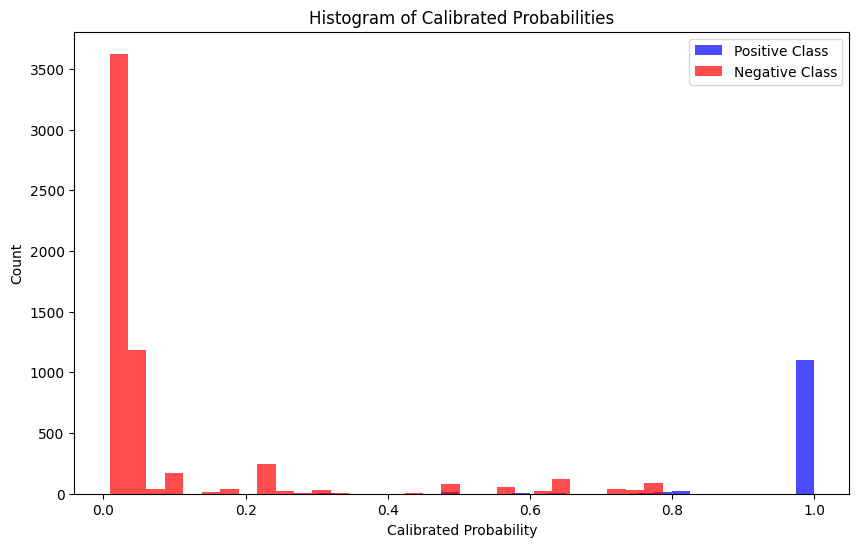

In [100]:
import matplotlib.pyplot as plt

# Get the calibrated probabilities
calibrated_probabilities = see['AdjustedBehaviourScore']

# Split the data into positive and negative classes based on the updated requirement
positive_class = calibrated_probabilities[see['Ever90'] == 1]
negative_class = calibrated_probabilities[see['Ever90'] == 0]

# Plot histograms of calibrated probabilities with actual counts instead of density
plt.figure(figsize=(10, 6))
plt.hist(positive_class, bins=30, color='blue', alpha=0.7, label='Positive Class')
plt.hist(negative_class, bins=30, color='red', alpha=0.7, label='Negative Class')
plt.xlabel('Calibrated Probability')
plt.ylabel('Count')
plt.title('Histogram of Calibrated Probabilities')
plt.legend()
plt.show()




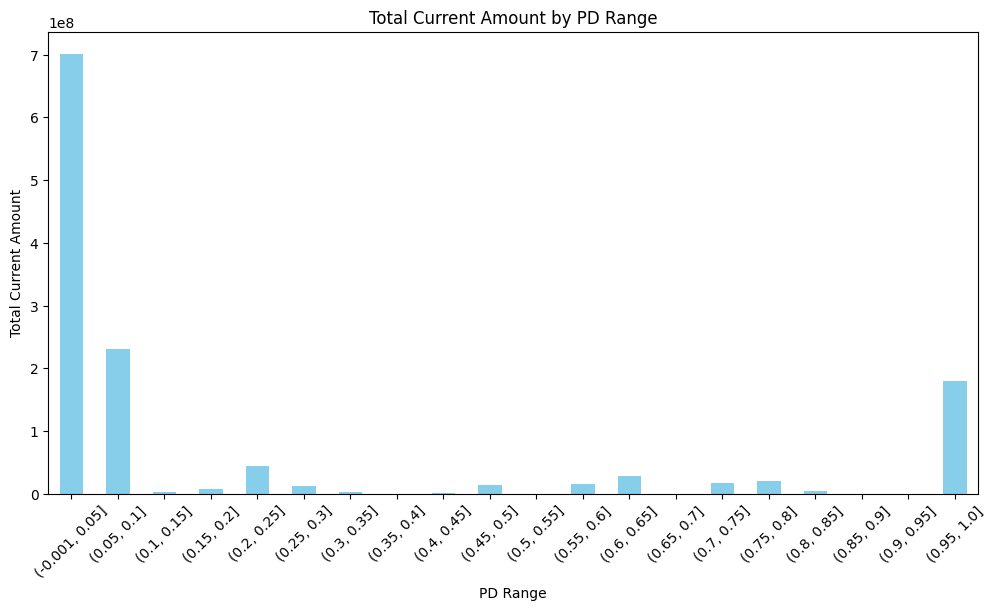

In [101]:

tt = see.copy()


# Define PD ranges (for example, 0-0.1, 0.1-0.2, ..., 0.9-1.0)
pd_bins = np.linspace(0, 1, 21)  # 10 equal intervals from 0 to 1
tt['PDCategory'] = pd.cut(tt['AdjustedBehaviourScore'], pd_bins, include_lowest=True, right=True)

# Group by PD category and sum 'CurrentAmount' within each category
pd_grouped = tt.groupby('PDCategory')['CurrentAmount'].sum()

# Plot
plt.figure(figsize=(12, 6))
pd_grouped.plot(kind='bar', color='skyblue')
plt.xlabel('PD Range')
plt.ylabel('Total Current Amount')
plt.title('Total Current Amount by PD Range')
plt.xticks(rotation=45)
plt.show()

In [102]:
print(np.min(see['AdjustedBehaviourScore']))
print(np.max(see['AdjustedBehaviourScore']))
print(np.mean(see['AdjustedBehaviourScore']))

print(np.mean(see['Score']))

0.008710691203618422
1.0
0.23895032797012983
24.27266771392713


In [103]:
print(np.mean(see[see.Stageing == 'Stage1'].AdjustedBehaviourScore))

print(np.mean(see[see.Stageing == 'Stage2'].AdjustedBehaviourScore))

0.04189676211001838
0.6134353905255644


In [104]:
see[(see.Stage == 'Stage2')& (see.Stageing == 'Stage1')].tail(20)


,AccountNumber,AccountStatus,SnapshotDate,MOB,DisbursedDate,CurrentAmount,RemainingTenor,CoappFlag,Ever30In6Months,WorstDelinquency6M,CurrentDelinquencyStatus,WorstDelinquency12M,Ever30In12Months,Ever90In12Months,Score,RiskClass,P,BehaviourModel,Ever90,PDScoreNew,UCScore,age,Inquiries12M,PropertyVolume,AdmissionModel,ApplicationScore,Stage,AppliedApplicationScore,AdjustedBehaviourScore,PD_Delta,SICR,Stageing,AdjustedBehaviourScore_1m,SnapshotDate_1m,Stage_1m,Stageing_1m,CurrentAmount_1m
5304,7833692,OPEN,2023-12-31,13.0,2022-11-10,293620.51,130.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,27.662599,E5,0.741876,0.216872,0.0,NaN,0.097,43.0,7.0,0.0,0.046197,0.945136,Stage2,0.009451,0.216872,0.207421,0.0,Stage1,0.216872,2023-11-30,Stage2,Stage1,294697.28
5305,7917743,OPEN,2023-12-31,7.0,2023-05-31,172979.72,137.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,27.662599,E5,0.741876,0.216872,0.0,NaN,0.045,50.0,4.0,0.0,0.034998,0.945136,Stage2,0.009451,0.216872,0.207421,0.0,Stage1,0.216872,2023-11-30,Stage2,Stage1,173507.91
5306,7247489,OPEN,2023-12-31,32.0,2021-04-08,115369.08,87.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,27.662599,E5,0.741876,0.216872,0.0,NaN,0.044,41.0,4.0,0.0,0.040467,0.837495,Stage2,0.008375,0.216872,0.208497,0.0,Stage1,0.057309,2023-11-30,Stage1,Stage1,115369.08
5307,7227556,OPEN,2023-12-31,33.0,2021-03-01,178277.60,205.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,27.662599,E5,0.741876,0.216872,0.0,NaN,0.052,37.0,2.0,1113120.0,0.034835,0.837495,Stage2,0.008375,0.216872,0.208497,0.0,Stage1,0.057309,2023-11-30,Stage1,Stage1,178277.60
5308,7719909,OPEN,2023-12-31,22.0,2022-02-11,92529.73,158.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,27.662599,E5,0.741876,0.216872,0.0,NaN,0.060,29.0,35.0,0.0,0.125330,0.837495,Stage2,0.008375,0.216872,0.208497,0.0,Stage1,0.025065,2023-11-30,Stage1,Stage1,92529.73
5309,7245574,OPEN,2023-12-31,32.0,2021-04-21,125026.22,40.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,39.215327,E5,0.741876,0.216872,0.0,NaN,0.085,29.0,10.0,0.0,0.063927,0.837495,Stage2,0.008375,0.216872,0.208497,0.0,Stage1,0.216872,2023-11-30,Stage2,Stage1,128112.23
5310,7757313,OPEN,2023-12-31,19.0,2022-05-31,95926.09,125.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,27.662599,E5,0.741876,0.216872,0.0,NaN,0.041,33.0,4.0,0.0,0.046276,0.837495,Stage2,0.008375,0.216872,0.208497,0.0,Stage1,0.025065,2023-11-30,Stage1,Stage1,95926.09
5311,7745912,OPEN,2023-12-31,19.0,2022-05-09,158836.76,160.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,27.662599,E5,0.741876,0.216872,0.0,NaN,0.072,29.0,32.0,0.0,0.117987,0.837495,Stage2,0.008375,0.216872,0.208497,0.0,Stage1,0.057309,2023-11-30,Stage1,Stage1,158836.76
5312,7176019,OPEN,2023-12-31,41.0,2020-07-01,33233.06,30.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,27.662599,E5,0.741876,0.216872,0.0,NaN,0.099,35.0,16.0,0.0,0.069850,0.837495,Stage2,0.008375,0.216872,0.208497,0.0,Stage1,0.057309,2023-11-30,Stage1,Stage1,33233.06
5313,7744204,OPEN,2023-12-31,20.0,2022-04-27,37087.33,40.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,27.662599,E5,0.741876,0.216872,0.0,NaN,0.027,38.0,5.0,0.0,0.042575,0.837495,Stage2,0.008375,0.216872,0.208497,0.0,Stage1,0.057309,2023-11-30,Stage1,Stage1,37087.33


In [105]:
see[see.WorstDelinquency6M > 1 ]

,AccountNumber,AccountStatus,SnapshotDate,MOB,DisbursedDate,CurrentAmount,RemainingTenor,CoappFlag,Ever30In6Months,WorstDelinquency6M,CurrentDelinquencyStatus,WorstDelinquency12M,Ever30In12Months,Ever90In12Months,Score,RiskClass,P,BehaviourModel,Ever90,PDScoreNew,UCScore,age,Inquiries12M,PropertyVolume,AdmissionModel,ApplicationScore,Stage,AppliedApplicationScore,AdjustedBehaviourScore,PD_Delta,SICR,Stageing,AdjustedBehaviourScore_1m,SnapshotDate_1m,Stage_1m,Stageing_1m,CurrentAmount_1m
122,7189855,OPEN,2023-12-31,40.0,2020-08-24,45823.27,140.0,1.0,1.0,2.0,0.0,2.0,1.0,0.0,3.126808,E4,0.611008,0.071093,0.0,NaN,0.205,48.0,7.0,0.0,0.050639,13.109632,Stage1,0.131096,0.071093,-0.060004,0.0,Stage1,0.071093,2023-11-30,Stage1,Stage1,45888.23
249,7689037,OPEN,2023-12-31,25.0,2021-11-09,26988.48,22.0,0.0,1.0,2.0,0.0,2.0,1.0,0.0,7.516150,E4,0.710064,0.168458,0.0,NaN,0.522,23.0,9.0,0.0,0.144086,19.834029,Stage1,0.198340,0.168458,-0.029883,0.0,Stage1,0.168458,2023-11-30,Stage1,Stage1,27941.29
427,5079058,OPEN,2023-12-31,71.0,2018-01-29,2472.05,1.0,1.0,1.0,2.0,0.0,2.0,1.0,0.0,3.126808,E4,0.611008,0.071093,0.0,NaN,0.178,28.0,15.0,0.0,0.089061,9.302893,Stage1,0.093029,0.071093,-0.021936,0.0,Stage1,0.071093,2023-11-30,Stage1,Stage1,4903.56
3789,7229479,OPEN,2023-12-31,35.0,2021-01-28,86003.35,61.0,0.0,1.0,2.0,0.0,2.0,1.0,0.0,18.137046,E5,0.710064,0.168458,0.0,NaN,0.437,24.0,21.0,0.0,0.166254,14.996189,Stage2,0.149962,0.168458,0.018496,0.0,Stage1,0.168458,2023-11-30,Stage2,Stage1,86685.81
3832,7661523,OPEN,2023-12-31,50.0,2019-10-17,215130.59,70.0,1.0,1.0,2.0,0.0,2.0,1.0,0.0,3.126808,E4,0.611008,0.071093,0.0,NaN,0.552,31.0,14.0,0.0,0.149898,5.169574,Stage1,0.051696,0.071093,0.019397,0.0,Stage1,0.248860,2023-11-30,Stage2,Stage1,212634.61
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6985,5003090,FROZEN,2023-12-31,86.0,2016-10-21,209828.76,115.0,0.0,1.0,5.0,9.0,5.0,1.0,1.0,100.000000,E8,0.999745,0.777314,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Stage3,0.000000,1.000000,1.000000,1.0,Stage3,1.000000,2023-11-30,Stage3,Stage3,209828.76
6986,5003124,FROZEN,2023-12-31,86.0,2016-10-24,176187.66,101.0,0.0,1.0,5.0,9.0,5.0,1.0,1.0,100.000000,E8,0.999745,0.777314,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Stage3,0.000000,1.000000,1.000000,1.0,Stage3,1.000000,2023-11-30,Stage3,Stage3,176187.66
6987,7155179,FROZEN,2023-12-31,44.0,2020-04-20,149705.86,93.0,0.0,1.0,5.0,9.0,5.0,1.0,1.0,100.000000,E8,0.999745,0.777314,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Stage3,0.000000,1.000000,1.000000,1.0,Stage3,1.000000,2023-11-30,Stage3,Stage3,151044.86
6988,7218001,FROZEN,2023-12-31,36.0,2020-12-07,145396.37,173.0,0.0,1.0,5.0,9.0,5.0,1.0,1.0,100.000000,E8,0.999745,0.777314,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Stage3,0.000000,1.000000,1.000000,1.0,Stage3,1.000000,2023-11-30,Stage3,Stage3,145396.37


In [106]:
see[see.AccountNumber == '7931488' ]

,AccountNumber,AccountStatus,SnapshotDate,MOB,DisbursedDate,CurrentAmount,RemainingTenor,CoappFlag,Ever30In6Months,WorstDelinquency6M,CurrentDelinquencyStatus,WorstDelinquency12M,Ever30In12Months,Ever90In12Months,Score,RiskClass,P,BehaviourModel,Ever90,PDScoreNew,UCScore,age,Inquiries12M,PropertyVolume,AdmissionModel,ApplicationScore,Stage,AppliedApplicationScore,AdjustedBehaviourScore,PD_Delta,SICR,Stageing,AdjustedBehaviourScore_1m,SnapshotDate_1m,Stage_1m,Stageing_1m,CurrentAmount_1m


In [107]:
see[  (see.BehaviourModel < 0.216872) & (see.ForberanceIn6Months == 1)  ]

AttributeError: 'DataFrame' object has no attribute 'ForberanceIn6Months'

In [108]:
see[  (see.Stageing != 'Stage2') & (see.CurrentDelinquencyStatus == 1)  ]

,AccountNumber,AccountStatus,SnapshotDate,MOB,DisbursedDate,CurrentAmount,RemainingTenor,CoappFlag,Ever30In6Months,WorstDelinquency6M,CurrentDelinquencyStatus,WorstDelinquency12M,Ever30In12Months,Ever90In12Months,Score,RiskClass,P,BehaviourModel,Ever90,PDScoreNew,UCScore,age,Inquiries12M,PropertyVolume,AdmissionModel,ApplicationScore,Stage,AppliedApplicationScore,AdjustedBehaviourScore,PD_Delta,SICR,Stageing,AdjustedBehaviourScore_1m,SnapshotDate_1m,Stage_1m,Stageing_1m,CurrentAmount_1m
2497,7286636,OPEN,2023-12-31,28.0,2021-08-12,369176.32,151.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,13.185339,E5,0.648305,0.099436,0.0,NaN,0.236,27.0,22.0,0.0,0.121552,9.302893,Stage2,0.093029,0.099436,0.006407,0.0,Stage1,0.008711,2023-11-30,Stage1,Stage1,369176.32
2498,7168909,OPEN,2023-12-31,42.0,2020-06-04,285944.92,137.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,13.185339,E5,0.648305,0.099436,0.0,NaN,0.155,29.0,6.0,0.0,0.064300,9.302893,Stage2,0.093029,0.099436,0.006407,0.0,Stage1,0.020187,2023-11-30,Stage1,Stage1,285944.92
3831,7710882,OPEN,2023-12-31,23.0,2022-01-20,94874.46,97.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,27.662599,E5,0.741876,0.216872,0.0,NaN,0.637,22.0,39.0,0.0,0.268502,19.834029,Stage2,0.198340,0.216872,0.018532,0.0,Stage1,0.216872,2023-11-30,Stage2,Stage1,95159.55
4033,5485347,OPEN,2023-12-31,61.0,2018-11-29,187414.39,47.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,20.396739,E5,0.648305,0.099436,0.0,NaN,0.657,62.0,-1.0,0.0,0.068054,7.423395,Stage2,0.074234,0.099436,0.025202,0.0,Stage1,0.099436,2023-11-30,Stage2,Stage1,189858.17
4034,7212285,OPEN,2023-12-31,37.0,2020-11-20,234954.02,143.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,13.185339,E5,0.648305,0.099436,0.0,NaN,0.714,35.0,32.0,0.0,0.237377,7.423395,Stage2,0.074234,0.099436,0.025202,0.0,Stage1,0.020187,2023-11-30,Stage1,Stage1,234954.02
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5319,7128978,OPEN,2023-12-31,47.0,2020-01-24,115139.77,145.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,27.662599,E5,0.741876,0.216872,0.0,NaN,0.043,48.0,7.0,0.0,0.038860,0.493233,Stage2,0.004932,0.216872,0.211940,0.0,Stage1,0.057309,2023-11-30,Stage1,Stage1,115139.77
5320,7773914,OPEN,2023-12-31,17.0,2022-07-06,268605.45,114.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,27.662599,E5,0.741876,0.216872,0.0,NaN,0.020,57.0,6.0,1047000.0,0.027636,0.493233,Stage2,0.004932,0.216872,0.211940,0.0,Stage1,0.057309,2023-11-30,Stage1,Stage1,268605.45
5321,7281439,OPEN,2023-12-31,29.0,2021-07-21,277460.03,151.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,27.662599,E5,0.741876,0.216872,0.0,NaN,0.036,45.0,17.0,0.0,0.053309,0.493233,Stage2,0.004932,0.216872,0.211940,0.0,Stage1,0.057309,2023-11-30,Stage1,Stage1,277460.03
5322,7147481,OPEN,2023-12-31,45.0,2020-03-18,102849.68,51.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,27.662599,E5,0.741876,0.216872,0.0,NaN,0.034,44.0,2.0,0.0,0.036041,0.493233,Stage2,0.004932,0.216872,0.211940,0.0,Stage1,0.025065,2023-11-30,Stage1,Stage1,102849.68


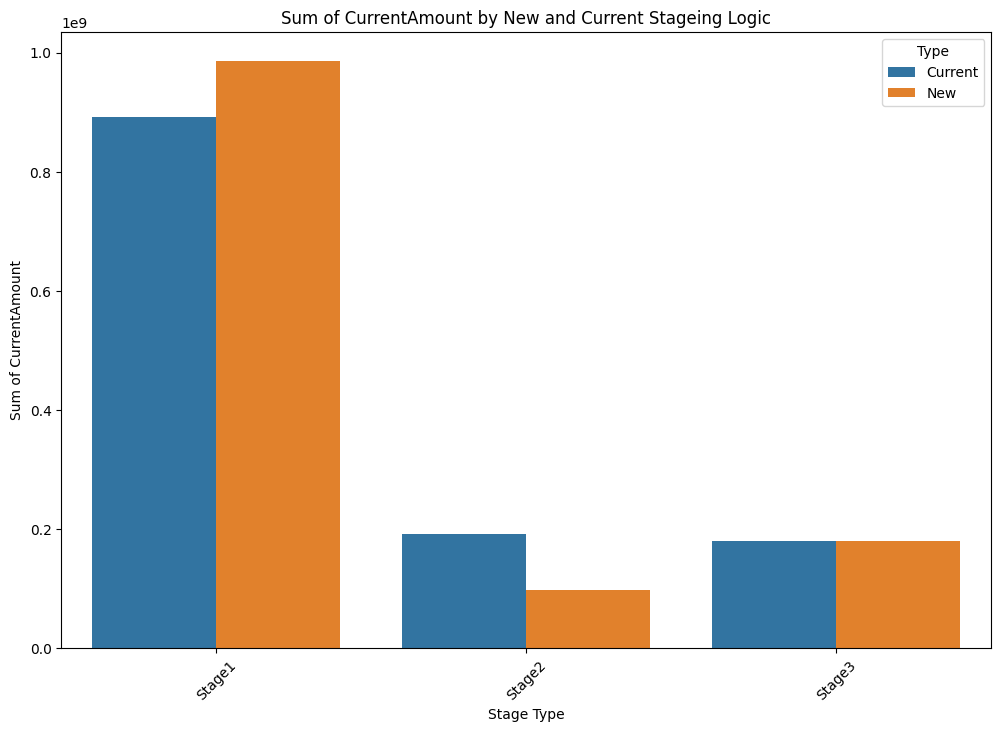

In [ ]:

import seaborn as sns

see.groupby('Stage')['CurrentAmount'].sum()
see.groupby('Stageing')['CurrentAmount'].sum()

# Assuming 'see' is your DataFrame and it's already loaded

# Calculate the sum of 'CurrentAmount' for each 'Stage'
stage_sum = see.groupby('Stage')['CurrentAmount'].sum().reset_index()

# Calculate the sum of 'CurrentAmount' for each 'Stageing'
stageing_sum = see.groupby('Stageing')['CurrentAmount'].sum().reset_index()

# Rename the columns for concatenation
stage_sum.rename(columns={'Stage': 'StageType', 'CurrentAmount': 'SumAmount'}, inplace=True)
stageing_sum.rename(columns={'Stageing': 'StageType', 'CurrentAmount': 'SumAmount'}, inplace=True)

# Add a new column to each DataFrame to distinguish between 'Stage' and 'Stageing'
stage_sum['Type'] = 'Current'
stageing_sum['Type'] = 'New'

# Concatenate the two DataFrames
combined_sum = pd.concat([stage_sum, stageing_sum])

# Now, let's create the combined bar plot
plt.figure(figsize=(12, 8))  # Adjust the size as needed
sns.barplot(x='StageType', y='SumAmount', hue='Type', data=combined_sum)
plt.title('Sum of CurrentAmount by New and Current Stageing Logic')
plt.ylabel('Sum of CurrentAmount')
plt.xlabel('Stage Type')
plt.xticks(rotation=45)  # Rotate the x-axis labels for better readability if needed
plt.show()


## skillnade är att om de blir sen med en faktura vilket kan vara 6 dagar så kommer de hoppa i den tidigare, den nya säger att först från 2 fakturor sen så är det mer kritiskt


Också att om de har varit 30 + senaste 12 månaderna

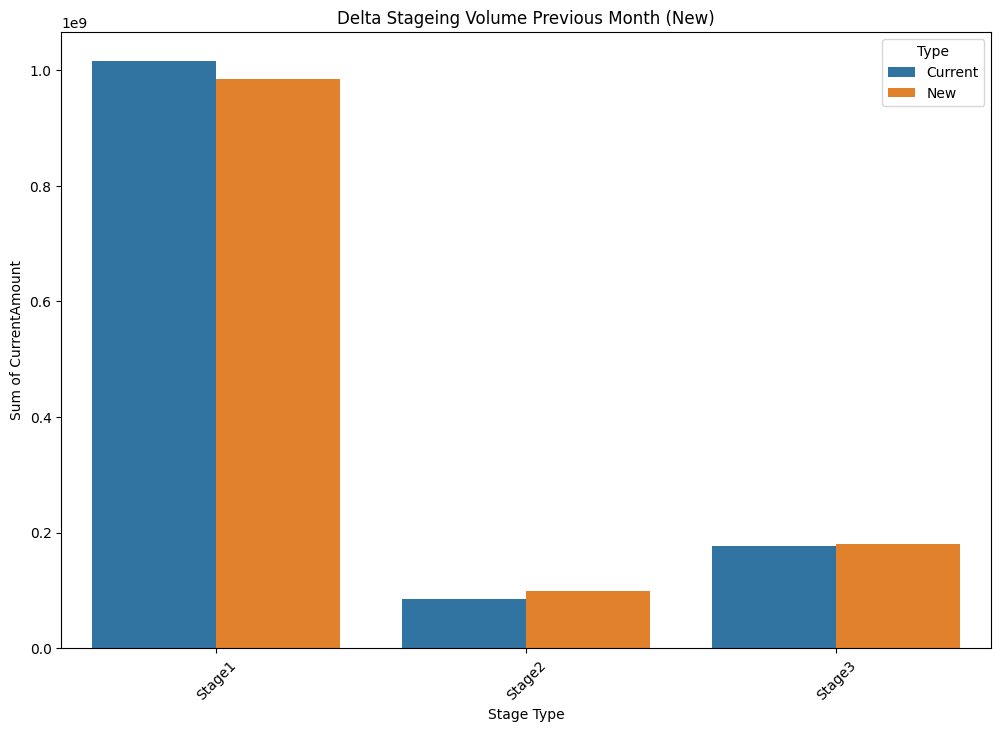

In [70]:

import seaborn as sns

# Assuming 'see' is your DataFrame and it's already loaded

# Calculate the sum of 'CurrentAmount' for each 'Stage'
stage_sum = see.groupby('Stageing_1m')['CurrentAmount_1m'].sum().reset_index()

# Calculate the sum of 'CurrentAmount' for each 'Stageing'
stageing_sum = see.groupby('Stageing')['CurrentAmount'].sum().reset_index()

# Rename the columns for concatenation
stage_sum.rename(columns={'Stageing_1m': 'StageType', 'CurrentAmount_1m': 'SumAmount'}, inplace=True)
stageing_sum.rename(columns={'Stageing': 'StageType', 'CurrentAmount': 'SumAmount'}, inplace=True)

# Add a new column to each DataFrame to distinguish between 'Stage' and 'Stageing'
stage_sum['Type'] = 'Current'
stageing_sum['Type'] = 'New'

# Concatenate the two DataFrames
combined_sum = pd.concat([stage_sum, stageing_sum])

# Now, let's create the combined bar plot
plt.figure(figsize=(12, 8))  # Adjust the size as needed
sns.barplot(x='StageType', y='SumAmount', hue='Type', data=combined_sum)
plt.title('Delta Stageing Volume Previous Month (New)')
plt.ylabel('Sum of CurrentAmount')
plt.xlabel('Stage Type')
plt.xticks(rotation=45)  # Rotate the x-axis labels for better readability if needed
plt.show()


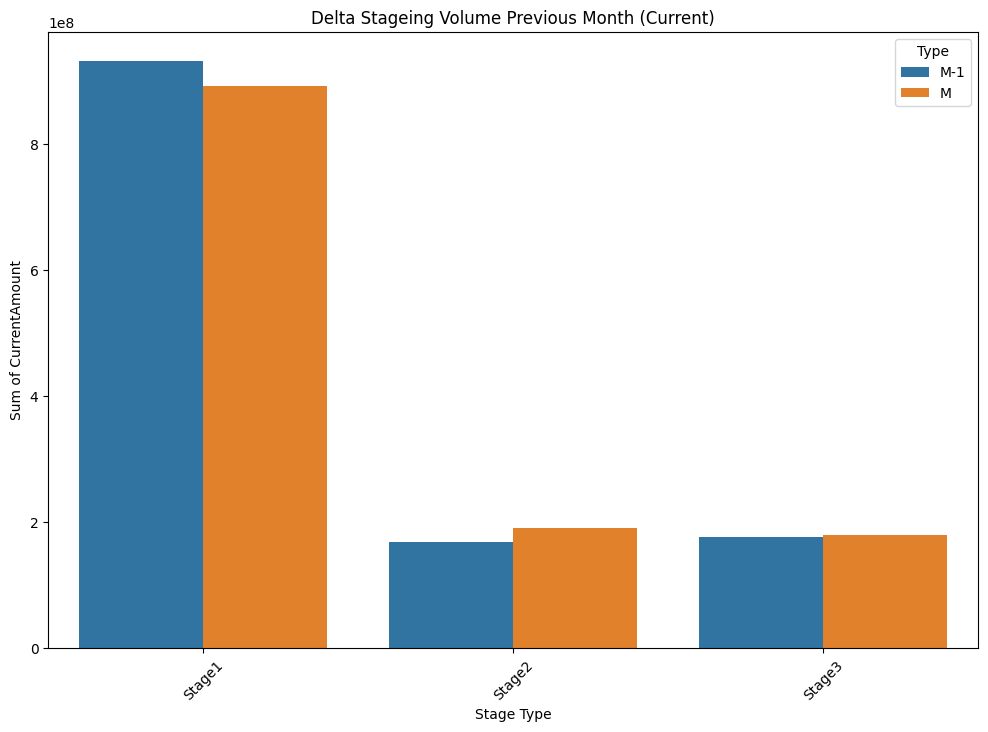

In [71]:

import seaborn as sns

# Assuming 'see' is your DataFrame and it's already loaded

# Calculate the sum of 'CurrentAmount' for each 'Stage'
stage_sum = see.groupby('Stage_1m')['CurrentAmount_1m'].sum().reset_index()

# Calculate the sum of 'CurrentAmount' for each 'Stageing'
stageing_sum = see.groupby('Stage')['CurrentAmount'].sum().reset_index()

# Rename the columns for concatenation
stage_sum.rename(columns={'Stage_1m': 'StageType', 'CurrentAmount_1m': 'SumAmount'}, inplace=True)
stageing_sum.rename(columns={'Stage': 'StageType', 'CurrentAmount': 'SumAmount'}, inplace=True)

# Add a new column to each DataFrame to distinguish between 'Stage' and 'Stageing'
stage_sum['Type'] = 'M-1'
stageing_sum['Type'] = 'M'

# Concatenate the two DataFrames
combined_sum = pd.concat([stage_sum, stageing_sum])

# Now, let's create the combined bar plot
plt.figure(figsize=(12, 8))  # Adjust the size as needed
sns.barplot(x='StageType', y='SumAmount', hue='Type', data=combined_sum)
plt.title('Delta Stageing Volume Previous Month (Current)')
plt.ylabel('Sum of CurrentAmount')
plt.xlabel('Stage Type')
plt.xticks(rotation=45)  # Rotate the x-axis labels for better readability if needed
plt.show()


In [120]:
combined_sum

,StageType,SumAmount,Type
0,Stage1,9.317552e+08,M-1
1,Stage2,1.677097e+08,M-1
2,Stage3,1.759726e+08,M-1
0,Stage1,8.923883e+08,M
1,Stage2,1.914005e+08,M
2,Stage3,1.803811e+08,M


In [121]:
reporting = see[['AccountNumber','SnapshotDate','MOB','DisbursedDate','CurrentAmount','CurrentAmount_1m','AppliedScore','AppliedScore_1m','Stageing','Stageing_1m','PD_Delta','SICR']]
reporting

KeyError: "['AppliedScore', 'AppliedScore_1m'] not in index"